In [1]:
# Cell 1: Kaggle-Friendly Setup

# Check installed versions to avoid redundant installs
!pip show torch torchvision torchaudio | grep Version || pip install torch torchvision torchaudio
!pip show albumentations || pip install albumentations
!pip show kaggle || pip install kaggle
!pip show gdown || pip install gdown

# (Optional) Confirm other common libraries are available
import torch, torchvision, torchaudio, cv2, matplotlib, seaborn, PIL, scipy, skimage, albumentations, gdown
print("✅ All required packages are ready.")


Version: 2.6.0+cu124
Version: 0.21.0+cu124
Version: 2.6.0+cu124
Name: albumentations
Version: 2.0.8
Summary: Fast, flexible, and advanced augmentation library for deep learning, computer vision, and medical imaging. Albumentations offers a wide range of transformations for both 2D (images, masks, bboxes, keypoints) and 3D (volumes, volumetric masks, keypoints) data, with optimized performance and seamless integration into ML workflows.
Home-page: https://albumentations.ai
Author: Vladimir Iglovikov
Author-email: 
License: MIT License

Copyright (c) 2017 Vladimir Iglovikov, Alexander Buslaev, Alexander Parinov,

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furni

In [2]:
# Cell 2: Kaggle-Friendly Imports

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import defaultdict
import os
import json
from tqdm.notebook import tqdm  # Notebook-friendly progress bar
import warnings
warnings.filterwarnings('ignore')

# Kaggle environment setup
KAGGLE_INPUT = Path("/kaggle/input")
KAGGLE_WORKING = Path("/kaggle/working")

# Check device (GPU is usually available on Kaggle)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# Optional: Display CUDA details if available
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024 ** 2:.1f} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved() / 1024 ** 2:.1f} MB")
else:
    print("⚠️ Running on CPU — enable GPU in Notebook Settings if needed.")


✅ Using device: cuda
GPU Name: Tesla T4
Memory Allocated: 0.0 MB
Memory Cached: 0.0 MB


In [3]:
# Cell 3: Setup Directories (Kaggle version)

import os

# In Kaggle, datasets are stored under /kaggle/input and outputs under /kaggle/working
DATA_DIR = '/kaggle/input'
OUTPUT_DIR = '/kaggle/working/hierarchical_panoptic_output'

# Create directory structure
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/checkpoints', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/visualizations', exist_ok=True)

print("Directory structure created successfully in Kaggle environment!")
print(f"DATA_DIR: {DATA_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")


Directory structure created successfully in Kaggle environment!
DATA_DIR: /kaggle/input
OUTPUT_DIR: /kaggle/working/hierarchical_panoptic_output


In [4]:
# Cell 5: Download CVPPP Dataset (Kaggle Version)
"""
CVPPP (Computer Vision Problems in Plant Phenotyping)
Leaf Counting & Segmentation Challenge – Essential Dataset (2017 version)

Download from: https://www.plant-phenotyping.org/datasets-home
Includes:
- LCC (Leaf Counting Challenge)
- LSC (Leaf Segmentation Challenge)
License: Research use only. Cite appropriately.
"""
"""
import os
from pathlib import Path

# =======================
# 🔧 Define Kaggle paths
# =======================
DATA_DIR = Path("/kaggle/working/cvppp")  # Writable path in Kaggle
os.makedirs(DATA_DIR, exist_ok=True)

# =======================
# 🌐 Option 1: Direct Download (official source)
# =======================
print("⬇️ Downloading CVPPP 2017 datasets... (this may take a few minutes)")
!wget -q -O {DATA_DIR}/CVPPP2017_LCC_training.zip "http://download.fz-juelich.de/ibg-2/CVPPP2017_LCC_training.zip"
!wget -q -O {DATA_DIR}/CVPPP2017_LSC_training.zip "http://download.fz-juelich.de/ibg-2/CVPPP2017_LSC_training.zip"

# =======================
# 📦 Extract archives
# =======================
print("📦 Extracting archives...")
!unzip -q {DATA_DIR}/CVPPP2017_LCC_training.zip -d {DATA_DIR}/CVPPP2017_LCC_training
!unzip -q {DATA_DIR}/CVPPP2017_LSC_training.zip -d {DATA_DIR}/CVPPP2017_LSC_training

# =======================
# 💾 Optional: Save to /kaggle/working for persistence
# =======================
print("✅ CVPPP 2017 essential datasets downloaded and extracted successfully.")
print(f"📁 Dataset path: {DATA_DIR}")
"""
# =======================
# ⚙️ Option 2: Use attached Kaggle dataset (no download)
# =======================
# If you've uploaded or attached the dataset manually, just uncomment below:

DATA_DIR = Path("/kaggle/input/cvppp-2017-dataset")
print(f"📁 Using pre-attached Kaggle dataset: {DATA_DIR}")


📁 Using pre-attached Kaggle dataset: /kaggle/input/cvppp-2017-dataset


In [5]:
# =====================================================
# 🌱 Cell 6 (Improved): Load PlantVillage Dataset (Kaggle Version)
# =====================================================
"""
PlantVillage Dataset for Disease Detection
Dataset source: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
Kaggle-optimized: uses attached dataset directly, no copy.
"""

import os
from pathlib import Path

# Default Kaggle input dataset path
ATTACHED_DATASET_DIR = Path("/kaggle/input/plantvillage-dataset")

print("\n" + "="*70)
print("🌿 Initializing PlantVillage Dataset (Kaggle)")
print("="*70)

# ✅ Check if dataset is attached
if ATTACHED_DATASET_DIR.exists():
    print("✅ PlantVillage dataset found in Kaggle input.")
    print(f"📁 Dataset path: {ATTACHED_DATASET_DIR}")

    # Use directly (no copy)
    PLANTVILLAGE_DIR = ATTACHED_DATASET_DIR

else:
    print("❌ PlantVillage dataset not found in /kaggle/input.")
    print("➡️ Please attach it manually:")
    print("   1. Click the 'Add Data' button on the right panel.")
    print("   2. Search for 'PlantVillage Dataset (abdallahalidev)'.")
    print("   3. Attach it to this notebook and rerun this cell.")
    PLANTVILLAGE_DIR = None

print("="*70)
if PLANTVILLAGE_DIR:
    print(f"🎉 Using PlantVillage dataset at: {PLANTVILLAGE_DIR}")
else:
    print("⚠️ Dataset not ready — attach before continuing.")
print("="*70 + "\n")



🌿 Initializing PlantVillage Dataset (Kaggle)
✅ PlantVillage dataset found in Kaggle input.
📁 Dataset path: /kaggle/input/plantvillage-dataset
🎉 Using PlantVillage dataset at: /kaggle/input/plantvillage-dataset



In [6]:
# Cell 5: Verify Dataset Download and Structure (Kaggle Version)
"""
Verifies that the CVPPP and PlantVillage datasets are correctly
attached or extracted in the Kaggle environment.


import os
from pathlib import Path

print("\n" + "="*70)
print("DATASET VERIFICATION (KAGGLE MODE)")
print("="*70)

# ---------------------------------------------------------------------
# 1️⃣ CVPPP Dataset
# ---------------------------------------------------------------------
try:
    print(f"\n1. CVPPP Dataset:")
    print(f"   Path: {CVPPP_DIR}")
except NameError:
    # Try common Kaggle working path
    CVPPP_DIR = "/kaggle/working/data/cvppp"
    if not os.path.exists(CVPPP_DIR):
        # Try alternative paths (some users unzip directly under /kaggle/working)
        alt_paths = list(Path("/kaggle/working").rglob("CVPPP2017_LSC_training"))
        CVPPP_DIR = str(alt_paths[0]) if alt_paths else "/kaggle/working"
    print(f"   (CVPPP_DIR not set, auto-detected: {CVPPP_DIR})")

if os.path.exists(CVPPP_DIR):
    print("   ✓ Directory exists")

    subdirs = [d for d in os.listdir(CVPPP_DIR) if os.path.isdir(os.path.join(CVPPP_DIR, d))]
    print(f"   Subdirectories found: {subdirs}")

    expected_folders = ['A1', 'A2', 'A3', 'A4']
    for folder in expected_folders:
        folder_path = os.path.join(CVPPP_DIR, folder)
        if os.path.exists(folder_path):
            rgb_files = list(Path(folder_path).glob('*_rgb.png'))
            label_files = list(Path(folder_path).glob('*_label.png'))
            print(f"   ✓ {folder}/: {len(rgb_files)} RGB images, {len(label_files)} label masks")
        else:
            print(f"   ✗ {folder}/ not found")

    # Fallback: show structure
    if not any(os.path.exists(os.path.join(CVPPP_DIR, f)) for f in expected_folders):
        print(f"\n   ⚠ Expected folders not found. Actual structure:")
        for root, dirs, files in os.walk(CVPPP_DIR):
            rel_root = os.path.relpath(root, CVPPP_DIR)
            indent = ' ' * 4 * rel_root.count(os.sep)
            print(f'{indent}{os.path.basename(root)}/')
            subindent = ' ' * 4 * (rel_root.count(os.sep) + 1)
            for file in files[:5]:
                print(f'{subindent}{file}')
            if len(files) > 5:
                print(f'{subindent}... and {len(files)-5} more files')
            if rel_root.count(os.sep) > 2:
                break
else:
    print("   ✗ Directory does not exist!")
    print("   → If you attached a CVPPP dataset, check the folder name or rerun extraction.")

# ---------------------------------------------------------------------
# 2️⃣ PlantVillage Dataset
# ---------------------------------------------------------------------
try:
    print(f"\n2. PlantVillage Dataset:")
    print(f"   Path: {PLANTVILLAGE_DIR}")
except NameError:
    # Default Kaggle path
    PLANTVILLAGE_DIR = "/kaggle/working/plantvillage"
    if not os.path.exists(PLANTVILLAGE_DIR):
        alt_paths = list(Path("/kaggle/working").rglob("plantvillage dataset"))
        PLANTVILLAGE_DIR = str(alt_paths[0]) if alt_paths else "/kaggle/input/plantvillage-dataset"
    print(f"   (PLANTVILLAGE_DIR not set, auto-detected: {PLANTVILLAGE_DIR})")

if os.path.exists(PLANTVILLAGE_DIR):
    print("   ✓ Directory exists")

    subdirs = [d for d in os.listdir(PLANTVILLAGE_DIR) if os.path.isdir(os.path.join(PLANTVILLAGE_DIR, d))]
    print(f"   Found {len(subdirs)} class directories")

    total_images = 0
    for subdir in subdirs[:5]:
        subdir_path = os.path.join(PLANTVILLAGE_DIR, subdir)
        images = list(Path(subdir_path).rglob("*.jpg")) + list(Path(subdir_path).rglob("*.JPG"))
        total_images += len(images)
        print(f"   ├─ {subdir}: {len(images)} images")

    if len(subdirs) > 5:
        print(f"   └─ ... and {len(subdirs)-5} more classes")

    print(f"   Total images found: {total_images}+")
    if total_images == 0:
        print(f"\n   ⚠ No images found. Checking actual structure:")
        for root, dirs, files in os.walk(PLANTVILLAGE_DIR):
            rel_root = os.path.relpath(root, PLANTVILLAGE_DIR)
            indent = ' ' * 4 * rel_root.count(os.sep)
            print(f'{indent}{os.path.basename(root)}/')
            subindent = ' ' * 4 * (rel_root.count(os.sep) + 1)
            for file in files[:5]:
                print(f'{subindent}{file}')
            if len(files) > 5:
                print(f'{subindent}... and {len(files)-5} more files')
            if rel_root.count(os.sep) > 2:
                break
else:
    print("   ✗ Directory does not exist!")
    print("   → Please attach or unzip the PlantVillage dataset under /kaggle/input or /kaggle/working.")

# ---------------------------------------------------------------------
# ✅ Summary
# ---------------------------------------------------------------------
print("\n" + "="*70)
print("RECOMMENDATIONS:")
print("="*70)
print("If datasets show 0 images:")
print("1. Confirm dataset folders exist under /kaggle/input or /kaggle/working.")
print("2. Verify extraction finished without errors.")
print("3. Adjust dataset paths above if nested under extra folders.")
print("4. Re-run this cell to verify again.")
print("="*70)
"""

'\nVerifies that the CVPPP and PlantVillage datasets are correctly\nattached or extracted in the Kaggle environment.\n\n\nimport os\nfrom pathlib import Path\n\nprint("\n" + "="*70)\nprint("DATASET VERIFICATION (KAGGLE MODE)")\nprint("="*70)\n\n# ---------------------------------------------------------------------\n# 1️⃣ CVPPP Dataset\n# ---------------------------------------------------------------------\ntry:\n    print(f"\n1. CVPPP Dataset:")\n    print(f"   Path: {CVPPP_DIR}")\nexcept NameError:\n    # Try common Kaggle working path\n    CVPPP_DIR = "/kaggle/working/data/cvppp"\n    if not os.path.exists(CVPPP_DIR):\n        # Try alternative paths (some users unzip directly under /kaggle/working)\n        alt_paths = list(Path("/kaggle/working").rglob("CVPPP2017_LSC_training"))\n        CVPPP_DIR = str(alt_paths[0]) if alt_paths else "/kaggle/working"\n    print(f"   (CVPPP_DIR not set, auto-detected: {CVPPP_DIR})")\n\nif os.path.exists(CVPPP_DIR):\n    print("   ✓ Directory exi

In [7]:
# Cell 5.6 (FAST MODE): Auto-Fix Dataset Paths for Kaggle
"""
Lightweight version for Kaggle:
- Quickly detects CVPPP and PlantVillage dataset folders.
- Avoids deep recursion and heavy file scans.
- Suitable for large datasets (completes in <3 seconds).
"""

import os
from pathlib import Path

print("\n" + "="*70)
print("AUTO-DETECTION OF DATASET PATHS (FAST MODE - KAGGLE)")
print("="*70)

# ---------------------------------------------------------------------
# Define search roots (light scan only)
# ---------------------------------------------------------------------
SEARCH_ROOTS = ["/kaggle/input", "/kaggle/working"]

def find_dataset(name_fragment):
    """Shallow search for a folder containing the given name fragment."""
    name_fragment = name_fragment.lower()
    for root in SEARCH_ROOTS:
        root_path = Path(root)
        for subdir in root_path.iterdir():
            if subdir.is_dir() and name_fragment in subdir.name.lower():
                return str(subdir)
            # One-level deep check only
            for subsub in subdir.glob("*"):
                if subsub.is_dir() and name_fragment in subsub.name.lower():
                    return str(subsub)
    return None

# ---------------------------------------------------------------------
# 🔍 Detect CVPPP
# ---------------------------------------------------------------------
cvppp_path = (
    find_dataset("cvppp2017")
    or find_dataset("cvppp")
    or find_dataset("leaf-counting")
)
if cvppp_path:
    print(f"✅ Found CVPPP dataset at: {cvppp_path}")
else:
    print("⚠️ CVPPP dataset not found in /kaggle/input or /kaggle/working")

# ---------------------------------------------------------------------
# 🔍 Detect PlantVillage
# ---------------------------------------------------------------------
pv_path = (
    find_dataset("plantvillage-dataset")
    or find_dataset("plantvillage")
)
if pv_path:
    print(f"✅ Found PlantVillage dataset at: {pv_path}")
else:
    print("⚠️ PlantVillage dataset not found in /kaggle/input or /kaggle/working")

# ---------------------------------------------------------------------
# Assign verified paths
# ---------------------------------------------------------------------
CVPPP_TRAINING_DIR = cvppp_path or "/kaggle/working/cvppp"
PLANTVILLAGE_SEGMENTED_DIR = pv_path or "/kaggle/input/plantvillage-dataset"

print("\n" + "="*70)
print("✅ VERIFIED PATHS")
print("="*70)
print(f"CVPPP_TRAINING_DIR = {CVPPP_TRAINING_DIR}")
print(f"PLANTVILLAGE_SEGMENTED_DIR = {PLANTVILLAGE_SEGMENTED_DIR}")

# ---------------------------------------------------------------------
# Quick verification (top-level only)
# ---------------------------------------------------------------------
def quick_verify(base_dir, exts=(".png", ".jpg", ".JPG")):
    if not os.path.exists(base_dir):
        print(f"✗ Path not found: {base_dir}")
        return
    files = []
    for ext in exts:
        files.extend(list(Path(base_dir).glob(f"*{ext}")))
        if len(files) > 5:
            break
    print(f"   Found {len(files)} image(s) directly under {Path(base_dir).name}")
    for f in files[:3]:
        print(f"    - {f.name}")
    if len(files) == 0:
        print("   ⚠ No top-level images found (dataset may be nested).")

print("\n" + "="*70)
print("VERIFYING FOUND DIRECTORIES (QUICK CHECK)")
print("="*70)
if cvppp_path:
    print("\n📂 CVPPP dataset:")
    quick_verify(cvppp_path)
else:
    print("\n❌ CVPPP not found.")

if pv_path:
    print("\n📂 PlantVillage dataset:")
    quick_verify(pv_path)
else:
    print("\n❌ PlantVillage not found.")

print("\n" + "="*70)
print("AUTO-DETECTION COMPLETE ✅ (FAST MODE)")
print("="*70)



AUTO-DETECTION OF DATASET PATHS (FAST MODE - KAGGLE)
✅ Found CVPPP dataset at: /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training
✅ Found PlantVillage dataset at: /kaggle/input/plantvillage-dataset

✅ VERIFIED PATHS
CVPPP_TRAINING_DIR = /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training
PLANTVILLAGE_SEGMENTED_DIR = /kaggle/input/plantvillage-dataset

VERIFYING FOUND DIRECTORIES (QUICK CHECK)

📂 CVPPP dataset:
   Found 0 image(s) directly under CVPPP2017_LCC_training
   ⚠ No top-level images found (dataset may be nested).

📂 PlantVillage dataset:
   Found 0 image(s) directly under plantvillage-dataset
   ⚠ No top-level images found (dataset may be nested).

AUTO-DETECTION COMPLETE ✅ (FAST MODE)


In [8]:
# Cell 5.7: Auto-Detect Nested Image Folders (Kaggle)

from pathlib import Path

def find_first_image_folder(base_dir, exts=(".png", ".jpg", ".JPG")):
    """Recursively find the first folder that actually contains images."""
    for subdir in Path(base_dir).rglob("*"):
        if subdir.is_dir():
            for ext in exts:
                if any(subdir.glob(f"*{ext}")):
                    return str(subdir)
    return base_dir  # fallback

print("\n" + "="*70)
print("NESTED DATASET FOLDER DETECTION")
print("="*70)

# CVPPP
cvppp_img_dir = find_first_image_folder(CVPPP_TRAINING_DIR)
print(f"🌿 CVPPP image root → {cvppp_img_dir}")

# PlantVillage
pv_img_dir = find_first_image_folder(PLANTVILLAGE_SEGMENTED_DIR)
print(f"🍃 PlantVillage image root → {pv_img_dir}")

# Update paths globally (for later dataset loading)
CVPPP_TRAINING_DIR = cvppp_img_dir
PLANTVILLAGE_SEGMENTED_DIR = pv_img_dir

print("\n✅ Dataset root paths auto-corrected for nested structures.")
print(f"CVPPP_TRAINING_DIR = {CVPPP_TRAINING_DIR}")
print(f"PLANTVILLAGE_SEGMENTED_DIR = {PLANTVILLAGE_SEGMENTED_DIR}")



NESTED DATASET FOLDER DETECTION
🌿 CVPPP image root → /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training/A2
🍃 PlantVillage image root → /kaggle/input/plantvillage-dataset/segmented/Tomato___Late_blight

✅ Dataset root paths auto-corrected for nested structures.
CVPPP_TRAINING_DIR = /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training/A2
PLANTVILLAGE_SEGMENTED_DIR = /kaggle/input/plantvillage-dataset/segmented/Tomato___Late_blight


In [9]:
# Helper: List available datasets and their structure
!ls -R /kaggle/input | head -n 50


/kaggle/input:
cvppp-2017-dataset
plantvillage-dataset

/kaggle/input/cvppp-2017-dataset:
CVPPP2017_LCC_training

/kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training:
LCC 2017 data description and further details.pdf
training

/kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training:
A1
A2
A3
A4

/kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training/A1:
A1.csv
plant001_centers.png
plant001_fg.png
plant001_rgb.png
plant002_centers.png
plant002_fg.png
plant002_rgb.png
plant005_centers.png
plant005_fg.png
plant005_rgb.png
plant006_centers.png
plant006_fg.png
plant006_rgb.png
plant007_centers.png
plant007_fg.png
plant007_rgb.png
plant008_centers.png
plant008_fg.png
plant008_rgb.png
plant010_centers.png
plant010_fg.png
plant010_rgb.png
plant011_centers.png
plant011_fg.png
plant011_rgb.png
plant012_centers.png
plant012_fg.png
plant012_rgb.png
plant013_centers.png
plant013_fg.png
plant013_rgb.png
plant015_centers.png
^C


In [20]:
# ================================================================
# FAST MODE: Auto-Detect CVPPP & PlantVillage Dataset Paths (Kaggle)
# ================================================================
import os
from pathlib import Path

print("\n" + "="*70)
print("AUTO-DETECTION OF DATASET PATHS (FAST MODE - KAGGLE)")
print("="*70)

# ----------------------------------------------------------------
# Search roots (shallow scan)
# ----------------------------------------------------------------
SEARCH_ROOTS = ["/kaggle/input", "/kaggle/working"]

def find_dataset_quick(name_fragment):
    for root in SEARCH_ROOTS:
        root_path = Path(root)
        if not root_path.exists():
            continue
        for sub in root_path.iterdir():
            if sub.is_dir() and name_fragment.lower() in sub.name.lower():
                return str(sub)
            # one level deeper
            for sub2 in sub.iterdir():
                if sub2.is_dir() and name_fragment.lower() in sub2.name.lower():
                    return str(sub2)
    return None

# ----------------------------------------------------------------
# Detect datasets
# ----------------------------------------------------------------
cvppp_path = find_dataset_quick("cvppp") or find_dataset_quick("CVPPP2017_LSC_training")
pv_path = find_dataset_quick("plantvillage") or find_dataset_quick("plantvillage dataset")

# ----------------------------------------------------------------
# Report results
# ----------------------------------------------------------------
if cvppp_path:
    print(f"✅ Found CVPPP dataset at: {cvppp_path}")
else:
    print("⚠️ CVPPP dataset not found in /kaggle/input or /kaggle/working")

if pv_path:
    print(f"✅ Found PlantVillage dataset at: {pv_path}")
else:
    print("⚠️ PlantVillage dataset not found in /kaggle/input or /kaggle/working")

# ----------------------------------------------------------------
# Assign and print verified paths
# ----------------------------------------------------------------
CVPPP_TRAINING_DIR = cvppp_path or "/kaggle/input/cvppp"
PLANTVILLAGE_SEGMENTED_DIR = pv_path or "/kaggle/input/plantvillage"

print("\n" + "="*70)
print("✅ VERIFIED PATHS")
print("="*70)
print(f"CVPPP_TRAINING_DIR = {CVPPP_TRAINING_DIR}")
print(f"PLANTVILLAGE_SEGMENTED_DIR = {PLANTVILLAGE_SEGMENTED_DIR}")

# ----------------------------------------------------------------
# Quick verification (no deep recursion)
# ----------------------------------------------------------------
def quick_verify(base_dir, exts=(".png", ".jpg", ".JPG")):
    if not os.path.exists(base_dir):
        print(f"✗ Path not found: {base_dir}")
        return
    count = 0
    for sub in Path(base_dir).iterdir():
        if sub.is_file() and sub.suffix.lower() in exts:
            count += 1
    print(f"   Found {count} image(s) directly under {base_dir}")
    if count == 0:
        print("   ⚠ No top-level images found (dataset may be nested).")

print("\n" + "="*70)
print("VERIFYING FOUND DIRECTORIES (QUICK CHECK)")
print("="*70)
if cvppp_path:
    print("\n📂 CVPPP dataset:")
    quick_verify(cvppp_path)
if pv_path:
    print("\n📂 PlantVillage dataset:")
    quick_verify(pv_path)

print("\n" + "="*70)
print("AUTO-DETECTION COMPLETE ✅ (FAST MODE)")
print("="*70)



AUTO-DETECTION OF DATASET PATHS (FAST MODE - KAGGLE)
✅ Found CVPPP dataset at: /kaggle/input/cvppp-2017-dataset
✅ Found PlantVillage dataset at: /kaggle/input/plantvillage-dataset

✅ VERIFIED PATHS
CVPPP_TRAINING_DIR = /kaggle/input/cvppp-2017-dataset
PLANTVILLAGE_SEGMENTED_DIR = /kaggle/input/plantvillage-dataset

VERIFYING FOUND DIRECTORIES (QUICK CHECK)

📂 CVPPP dataset:
   Found 0 image(s) directly under /kaggle/input/cvppp-2017-dataset
   ⚠ No top-level images found (dataset may be nested).

📂 PlantVillage dataset:
   Found 0 image(s) directly under /kaggle/input/plantvillage-dataset
   ⚠ No top-level images found (dataset may be nested).

AUTO-DETECTION COMPLETE ✅ (FAST MODE)


In [21]:
# ================================================================
# NESTED DATASET FOLDER DETECTION (KAGGLE VERSION)
# ================================================================
import os
from pathlib import Path

print("\n" + "="*70)
print("NESTED DATASET FOLDER DETECTION (KAGGLE MODE)")
print("="*70)

# --- Detect nested structure for CVPPP ---
cvppp_base = Path("/kaggle/working/cvppp")
if not cvppp_base.exists():
    print("⚠️ CVPPP not found in working directory, skipping...")
    cvppp_root = None
else:
    rgb_candidates = list(cvppp_base.rglob("*_rgb.png"))
    if rgb_candidates:
        cvppp_root = str(rgb_candidates[0].parent.parent)
        print(f"🌿 CVPPP image root → {cvppp_root}")
    else:
        print("⚠️ No RGB images found under /kaggle/working/cvppp")
        cvppp_root = str(cvppp_base)

# --- Detect nested structure for PlantVillage ---
pv_base = Path("/kaggle/input/plantvillage-dataset")
pv_nested = None
if pv_base.exists():
    for sub in pv_base.rglob("Tomato___Late_blight"):
        if sub.is_dir():
            pv_nested = str(sub)
            break
    if pv_nested:
        print(f"🍃 PlantVillage image root → {pv_nested}")
    else:
        print("⚠️ Could not find segmented subfolder (e.g. Tomato___Late_blight)")
        pv_nested = str(pv_base)
else:
    print("⚠️ PlantVillage dataset base not found.")
    pv_nested = None

# --- Assign updated paths ---
CVPPP_TRAINING_DIR = cvppp_root or "/kaggle/working/cvppp"
PLANTVILLAGE_SEGMENTED_DIR = pv_nested or "/kaggle/input/plantvillage-dataset"

print("\n✅ Dataset root paths auto-corrected for nested structures.")
print(f"CVPPP_TRAINING_DIR = {CVPPP_TRAINING_DIR}")
print(f"PLANTVILLAGE_SEGMENTED_DIR = {PLANTVILLAGE_SEGMENTED_DIR}")
print("="*70)



NESTED DATASET FOLDER DETECTION (KAGGLE MODE)
⚠️ CVPPP not found in working directory, skipping...
🍃 PlantVillage image root → /kaggle/input/plantvillage-dataset/segmented/Tomato___Late_blight

✅ Dataset root paths auto-corrected for nested structures.
CVPPP_TRAINING_DIR = /kaggle/working/cvppp
PLANTVILLAGE_SEGMENTED_DIR = /kaggle/input/plantvillage-dataset/segmented/Tomato___Late_blight


In [22]:
# Cell 11 (Kaggle): Fix and Verify Dataset Paths Based on Actual Structure
"""
Adapts the path correction and verification logic for Kaggle environment.
Integrates with Fast Mode + Nested Detection cells (Cells 5.6 & 5.7).
"""

import os
from pathlib import Path

print("\n" + "="*70)
print("FIXING AND VERIFYING DATASET PATHS (KAGGLE VERSION)")
print("="*70)

# ---------------------------------------------------------------------
# ✅ 1. Use already-detected or fallback paths

CVPPP_TRAINING_DIR = "/kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training"
PLANTVILLAGE_SEGMENTED_DIR = "/kaggle/input/plantvillage-dataset/segmented"



# Fallbacks if environment variables not set
if not os.path.exists(CVPPP_TRAINING_DIR):
    CVPPP_TRAINING_DIR = "/kaggle/working/cvppp"
if not os.path.exists(PLANTVILLAGE_SEGMENTED_DIR):
    PLANTVILLAGE_SEGMENTED_DIR = "/kaggle/input/plantvillage-dataset/segmented"

print(f"CVPPP_TRAINING_DIR = {CVPPP_TRAINING_DIR}")
print(f"PLANTVILLAGE_SEGMENTED_DIR = {PLANTVILLAGE_SEGMENTED_DIR}")

# ---------------------------------------------------------------------
# ✅ 2. Verify CVPPP dataset structure
# ---------------------------------------------------------------------
print("\n🔍 Verifying CVPPP dataset structure...")
if os.path.exists(CVPPP_TRAINING_DIR):
    print(f"✓ Directory exists: {CVPPP_TRAINING_DIR}")

    rgb_files = sorted([
        f for f in Path(CVPPP_TRAINING_DIR).rglob('*_rgb.png')
        if '__MACOSX' not in str(f) and not f.name.startswith('._')
    ])

    print(f"  Found {len(rgb_files)} RGB image(s)")
    if rgb_files:
        print(f"  Example file: {rgb_files[0].relative_to(Path(CVPPP_TRAINING_DIR))}")
        print(f"  Likely training root: {rgb_files[0].parent.parent}")
    else:
        print("  ⚠ No *_rgb.png files found — check dataset extraction.")
else:
    print(f"✗ ERROR: Directory not found: {CVPPP_TRAINING_DIR}")

# ---------------------------------------------------------------------
# ✅ 3. Verify PlantVillage dataset structure
# ---------------------------------------------------------------------
print("\n🔍 Verifying PlantVillage dataset structure...")
if os.path.exists(PLANTVILLAGE_SEGMENTED_DIR):
    print(f"✓ Directory exists: {PLANTVILLAGE_SEGMENTED_DIR}")

    subdirs = [d for d in Path(PLANTVILLAGE_SEGMENTED_DIR).iterdir() if d.is_dir()]
    if subdirs:
        print(f"  Found {len(subdirs)} class folders.")
        first_class = subdirs[0]
        imgs = list(first_class.glob('*.jpg')) + list(first_class.glob('*.JPG'))
        if imgs:
            print(f"  ✓ {len(imgs)} images found in '{first_class.name}' (sample: {imgs[0].name})")
        else:
            print(f"  ⚠ No images found in '{first_class.name}' — check dataset extraction.")
    else:
        print("  ⚠ No class subdirectories detected.")
else:
    print(f"✗ ERROR: Directory not found: {PLANTVILLAGE_SEGMENTED_DIR}")

print("\n" + "="*70)
print("✅ DATASET PATHS VERIFIED (KAGGLE VERSION)")
print("="*70)



FIXING AND VERIFYING DATASET PATHS (KAGGLE VERSION)
CVPPP_TRAINING_DIR = /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training
PLANTVILLAGE_SEGMENTED_DIR = /kaggle/input/plantvillage-dataset/segmented

🔍 Verifying CVPPP dataset structure...
✓ Directory exists: /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training
  Found 810 RGB image(s)
  Example file: A1/plant001_rgb.png
  Likely training root: /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training

🔍 Verifying PlantVillage dataset structure...
✓ Directory exists: /kaggle/input/plantvillage-dataset/segmented
  Found 38 class folders.
  ✓ 1909 images found in 'Tomato___Late_blight' (sample: 081d1e25-3f06-46a1-95ef-d10a62faa80f___GHLB2 Leaf 8600_final_masked.jpg)

✅ DATASET PATHS VERIFIED (KAGGLE VERSION)


In [23]:
# Cell 5.5 (Kaggle): Update Dataset Paths Configuration
"""
Configuration with corrected and verified Kaggle paths
"""

print("\n" + "="*70)
print("DATASET CONFIGURATION (KAGGLE VERSION)")
print("="*70)

# ✅ PlantVillage dataset
PLANTVILLAGE_SEGMENTED_DIR = "/kaggle/input/plantvillage-dataset/segmented"
print(f"✓ PlantVillage: {PLANTVILLAGE_SEGMENTED_DIR}")

# ✅ CVPPP dataset (already verified in previous step)
CVPPP_TRAINING_DIR = "/kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training"

if os.path.exists(CVPPP_TRAINING_DIR):
    print(f"✓ CVPPP: {CVPPP_TRAINING_DIR}")
    USE_CVPPP = True
else:
    print(f"⚠ CVPPP: Not available")
    print(f"   → Proceeding with PlantVillage only")
    USE_CVPPP = False

print("\n📊 Dataset Summary:")
print(f"  - PlantVillage: ✓ Available (≈54K images)")
print(f"  - CVPPP: {'✓ Available' if USE_CVPPP else '✗ Not available'}")

if not USE_CVPPP:
    print("\n💡 Note: Training will use PlantVillage only")
    print("   This provides:")
    print("   - Disease detection on leaves ✓")
    print("   - Leaf segmentation (synthetic) ✓")
    print("   - 2-level hierarchy: background → leaves → disease spots")

print("="*70)



DATASET CONFIGURATION (KAGGLE VERSION)
✓ PlantVillage: /kaggle/input/plantvillage-dataset/segmented
✓ CVPPP: /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training

📊 Dataset Summary:
  - PlantVillage: ✓ Available (≈54K images)
  - CVPPP: ✓ Available


In [24]:
# Cell 6 (Kaggle): CVPPP Dataset Loader (with success confirmation)
"""
Real CVPPP dataset loader for leaf counting and segmentation.
Kaggle-adapted version to work with verified structure:
    /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training/A1–A4
"""

import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
from pathlib import Path

class CVPPPDataset(Dataset):
    """
    CVPPP 2017 dataset loader (LCC/LSC) for leaf counting and segmentation.
    Automatically detects *_rgb.png images and corresponding masks.
    """

    def __init__(self, root_dir="/kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training",
                 split='train', image_size=(512, 512), transform=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.image_size = image_size
        self.transform = transform

        print("\n" + "="*70)
        print(f"🌿 Initializing CVPPP Dataset ({split} split)")
        print("="*70)

        if not self.root_dir.exists():
            raise ValueError(f"❌ CVPPP root directory does not exist: {root_dir}")

        # ------------------------------------------------------------------
        # Find all RGB images in the training directory (A1–A4 folders)
        # ------------------------------------------------------------------
        self.image_files = sorted([
            f for f in self.root_dir.glob('**/*_rgb.png')
            if not f.name.startswith('._')
        ])

        # Fallback: generic .png filter (if *_rgb missing)
        if len(self.image_files) == 0:
            all_pngs = sorted([
                f for f in self.root_dir.glob('**/*.png')
                if not f.name.startswith('._')
            ])
            self.image_files = [
                f for f in all_pngs
                if 'label' not in f.name.lower()
                and 'mask' not in f.name.lower()
                and 'fg' not in f.name.lower()
            ]

        if len(self.image_files) == 0:
            print(f"⚠ No RGB images found in {root_dir}")
            print("   Sample directory contents (up to 20 files):")
            for i, item in enumerate(self.root_dir.rglob('*')):
                if item.is_file():
                    print(f"     {item.relative_to(self.root_dir)}")
                    if i > 20:
                        break

        # ------------------------------------------------------------------
        # Train / validation split (80/20)
        # ------------------------------------------------------------------
        split_idx = int(len(self.image_files) * 0.8)
        if split == 'train':
            self.image_files = self.image_files[:split_idx]
        else:
            self.image_files = self.image_files[split_idx:]

        print(f"✅ Loaded {len(self.image_files)} images from CVPPP ({split} set)")

        # ------------------------------------------------------------------
        # Confirmation message
        # ------------------------------------------------------------------
        print(f"🎉 CVPPP Dataset initialized successfully!")
        print(f"📁 Root path: {self.root_dir}")
        print(f"📸 Example image: {self.image_files[0].name if len(self.image_files) > 0 else 'No images found!'}")
        print("="*70 + "\n")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # ------------------------------------------------------------------
        # Load RGB image
        # ------------------------------------------------------------------
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path))
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.image_size)

        # ------------------------------------------------------------------
        # Load leaf instance masks (multiple naming patterns)
        # ------------------------------------------------------------------
        base_name = img_path.stem.replace('_rgb', '')
        label_dir = img_path.parent

        leaf_masks = []

        # Pattern 1: *_label*.png
        label_files = sorted(label_dir.glob(f'{base_name}_label*.png'))
        if not label_files:
            # Pattern 2: *_fg*.png
            label_files = sorted(label_dir.glob(f'{base_name}_fg*.png'))
        if not label_files:
            # Pattern 3: any *_*.png excluding *_rgb
            label_files = [
                f for f in sorted(label_dir.glob(f'{base_name}_*.png'))
                if 'rgb' not in f.name
            ]

        for label_file in label_files:
            mask = cv2.imread(str(label_file), cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
                mask = (mask > 0).astype(np.float32)
                leaf_masks.append(mask)

        if len(leaf_masks) == 0:
            # If no annotation masks exist, create a zero mask
            leaf_masks = np.zeros((1, *self.image_size), dtype=np.float32)
        else:
            leaf_masks = np.stack(leaf_masks, axis=0)

        # ------------------------------------------------------------------
        # Convert to PyTorch tensors
        # ------------------------------------------------------------------
        image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        leaf_masks = torch.from_numpy(leaf_masks).float()

        return {
            'image': image,
            'leaf_masks': leaf_masks,
            'dataset': 'cvppp'
        }


In [25]:
# Test the CVPPP dataset loader (Kaggle)
cvppp_dataset = CVPPPDataset(
    root_dir="/kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training",
    split="train"
)



🌿 Initializing CVPPP Dataset (train split)
✅ Loaded 648 images from CVPPP (train set)
🎉 CVPPP Dataset initialized successfully!
📁 Root path: /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training
📸 Example image: plant001_rgb.png



In [58]:
# Cell 7 (Kaggle): PlantVillage Dataset Loader (Kaggle-ready version)
class PlantVillageDataset(Dataset):
    """
    Real PlantVillage dataset loader for disease detection
    Updated for Kaggle environment and verified segmented structure.
    """

    def __init__(self, root_dir, split='train', image_size=(512, 512), transform=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.image_size = image_size
        self.transform = transform

        if not self.root_dir.exists():
            raise ValueError(f"❌ PlantVillage root directory does not exist: {root_dir}")

        print(f"\n📂 Initializing PlantVillage dataset from: {self.root_dir}")

        # Load all images from subdirectories (class folders)
        self.image_files = []
        class_counts = {}

        for class_dir in self.root_dir.iterdir():
            if class_dir.is_dir():
                # Get all image files
                images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG')) \
                       + list(class_dir.glob('*.png')) + list(class_dir.glob('*.PNG')) \
                       + list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.JPEG'))

                if images:
                    class_counts[class_dir.name] = len(images)
                    self.image_files.extend(images)

        if not self.image_files:
            print(f"⚠ WARNING: No images found in {root_dir}")
            for subdir in self.root_dir.iterdir():
                if subdir.is_dir():
                    print(f"  └─ {subdir.name}: {len(list(subdir.glob('*')))} files")
        else:
            print(f"✅ Found {len(self.image_files)} total images across {len(class_counts)} classes")
            print("📊 Top classes:")
            for cls, cnt in list(class_counts.items())[:5]:
                print(f"   - {cls}: {cnt} images")

        # Split train/val
        split_idx = int(len(self.image_files) * 0.8)
        if split == 'train':
            self.image_files = self.image_files[:split_idx]
        else:
            self.image_files = self.image_files[split_idx:]

        print(f"📁 Loaded {len(self.image_files)} images for PlantVillage {split} set ✅")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path))
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.image_size)

        # Simple synthetic leaf mask (center ellipse)
        leaf_mask = np.zeros(self.image_size, dtype=np.float32)
        center_x, center_y = self.image_size[1] // 2, self.image_size[0] // 2
        cv2.ellipse(leaf_mask, (center_x, center_y),
                   (self.image_size[1]//3, self.image_size[0]//3),
                   0, 0, 360, 1, -1)

        # Detect disease spots
        disease_mask = self._detect_disease_spots(image)

        # Convert to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        leaf_mask = torch.from_numpy(leaf_mask).float()
        disease_mask = torch.from_numpy(disease_mask).float()

        return {
            'image': image,
            'leaf_mask': leaf_mask,
            'disease_masks': disease_mask,
            'dataset': 'plantvillage'
        }

    def _detect_disease_spots(self, image):
        """Simple disease spot detection using color thresholding"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Brownish/yellowish thresholds
        lower_brown = np.array([10, 40, 40])
        upper_brown = np.array([30, 255, 200])
        mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)

        lower_yellow = np.array([20, 100, 100])
        upper_yellow = np.array([40, 255, 255])
        mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

        disease_mask = cv2.bitwise_or(mask_brown, mask_yellow)
        disease_mask = cv2.resize(disease_mask, self.image_size, interpolation=cv2.INTER_NEAREST)
        disease_mask = (disease_mask > 0).astype(np.float32)

        return disease_mask


# ✅ Example test after defining class
PLANTVILLAGE_SEGMENTED_DIR = "/kaggle/input/plantvillage-dataset/segmented"
test_dataset = PlantVillageDataset(PLANTVILLAGE_SEGMENTED_DIR, split='train')
print(f"\n✅ Dataset successfully initialized with {len(test_dataset)} training images.")



📂 Initializing PlantVillage dataset from: /kaggle/input/plantvillage-dataset/segmented
✅ Found 54306 total images across 38 classes
📊 Top classes:
   - Tomato___Late_blight: 1909 images
   - Tomato___healthy: 1591 images
   - Grape___healthy: 423 images
   - Orange___Haunglongbing_(Citrus_greening): 5507 images
   - Soybean___healthy: 5090 images
📁 Loaded 43444 images for PlantVillage train set ✅

✅ Dataset successfully initialized with 43444 training images.


In [59]:
# Cell 8 (Kaggle): Multi-Dataset Loader (Updated with correct paths)
class MultiDatasetHierarchicalLoader(Dataset):
    """Combined dataset loader for hierarchical panoptic segmentation"""

    def __init__(self, cvppp_dir=None, plantvillage_dir=None,
                 split='train', image_size=(512, 512)):
        self.split = split
        self.image_size = image_size

        # Initialize datasets
        self.cvppp = None
        self.plantvillage = None

        print(f"\n{'='*70}")
        print(f"📦 Initializing Multi-Dataset Hierarchical Loader ({split} set)")
        print(f"{'='*70}")

        if cvppp_dir is not None and os.path.exists(cvppp_dir):
            try:
                print(f"🔹 Loading CVPPP from: {cvppp_dir}")
                self.cvppp = CVPPPDataset(cvppp_dir, split, image_size)
                print(f"   ✅ CVPPP loaded successfully with {len(self.cvppp)} samples")
            except Exception as e:
                print(f"   ❌ CVPPP failed: {e}")
        else:
            print("⚠️ Skipping CVPPP – path not found or not provided")

        if plantvillage_dir is not None and os.path.exists(plantvillage_dir):
            try:
                print(f"\n🔹 Loading PlantVillage from: {plantvillage_dir}")
                self.plantvillage = PlantVillageDataset(plantvillage_dir, split, image_size)
                print(f"   ✅ PlantVillage loaded successfully with {len(self.plantvillage)} samples")
            except Exception as e:
                print(f"   ❌ PlantVillage failed: {e}")
        else:
            print("⚠️ Skipping PlantVillage – path not found or not provided")

        self.samples = self._load_all_datasets()
        print(f"\n✅ Multi-dataset loader ready with {len(self.samples)} total samples.")

    def _load_all_datasets(self):
        """Combine samples from all datasets"""
        all_samples = []

        if self.cvppp is not None and len(self.cvppp) > 0:
            all_samples.extend([('cvppp', i) for i in range(len(self.cvppp))])
            print(f"  → Added {len(self.cvppp)} CVPPP samples")

        if self.plantvillage is not None and len(self.plantvillage) > 0:
            all_samples.extend([('plantvillage', i) for i in range(len(self.plantvillage))])
            print(f"  → Added {len(self.plantvillage)} PlantVillage samples")

        if not all_samples:
            raise ValueError(
                "❌ No datasets loaded! Check:\n"
                "1. Dataset paths are correct\n"
                "2. Datasets were downloaded/extracted properly\n"
                "3. Folder structure matches expected format"
            )

        print(f"\n📊 Total combined samples: {len(all_samples)}")
        return all_samples


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        dataset_name, dataset_idx = self.samples[idx]

        if dataset_name == 'cvppp':
            sample = self.cvppp[dataset_idx]
        elif dataset_name == 'plantvillage':
            sample = self.plantvillage[dataset_idx]
        else:
            raise ValueError(f"Unknown dataset type: {dataset_name}")

        return self._create_hierarchical_targets(sample)

    def _create_hierarchical_targets(self, sample):
        """Create hierarchical targets based on dataset"""
        image = sample['image']
        dataset_name = sample['dataset']

        targets = {'dataset': dataset_name}

        if dataset_name == 'cvppp':
            targets['leaf_instances'] = sample['leaf_masks']
        elif dataset_name == 'plantvillage':
            targets['leaf_mask'] = sample['leaf_mask']
            targets['disease_spots'] = sample['disease_masks']

        return image, targets


# ✅ Example test
CVPPP_TRAINING_DIR = "/kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training"
PLANTVILLAGE_SEGMENTED_DIR = "/kaggle/input/plantvillage-dataset/segmented"

multi_train_dataset = MultiDatasetHierarchicalLoader(
    cvppp_dir=CVPPP_TRAINING_DIR,
    plantvillage_dir=PLANTVILLAGE_SEGMENTED_DIR,
    split='train'
)

print(f"\n✅ Multi-dataset loader initialized successfully with {len(multi_train_dataset)} samples total.")


📦 Initializing Multi-Dataset Hierarchical Loader (train set)
🔹 Loading CVPPP from: /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training

🌿 Initializing CVPPP Dataset (train split)
✅ Loaded 648 images from CVPPP (train set)
🎉 CVPPP Dataset initialized successfully!
📁 Root path: /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training
📸 Example image: plant001_rgb.png

   ✅ CVPPP loaded successfully with 648 samples

🔹 Loading PlantVillage from: /kaggle/input/plantvillage-dataset/segmented

📂 Initializing PlantVillage dataset from: /kaggle/input/plantvillage-dataset/segmented
✅ Found 54306 total images across 38 classes
📊 Top classes:
   - Tomato___Late_blight: 1909 images
   - Tomato___healthy: 1591 images
   - Grape___healthy: 423 images
   - Orange___Haunglongbing_(Citrus_greening): 5507 images
   - Soybean___healthy: 5090 images
📁 Loaded 43444 images for PlantVillage train set ✅
   ✅ PlantVillage loaded successfully with 43444 samples
  → Added 648 CVPPP samples


In [60]:
# ==============================================================
# 🌿 Cell 8: Custom Collate Function (Kaggle-compatible version)
# ==============================================================

def hierarchical_collate_fn(batch):
    """
    Custom collate function for hierarchical multi-dataset batches.
    ✅ Works in Kaggle or Colab.
    ✅ Handles samples that are either dicts (PlantVillage) or (image, targets) tuples.
    ✅ Pads variable-sized instance masks and aligns target shapes.
    """
    if len(batch) == 0:
        return torch.tensor([]), {}

    images = []
    targets_list = []

    # ----------------------------------------------------------
    # 🔄 Normalize sample format: some datasets yield (img, tgt),
    # while others yield {"image":..., "leaf_mask":..., ...}
    # ----------------------------------------------------------
    for sample in batch:
        if isinstance(sample, tuple):
            image, targets = sample
        elif isinstance(sample, dict):
            image = sample.get("image")
            # keep rest of keys as targets
            targets = {k: v for k, v in sample.items() if k != "image"}
        else:
            raise TypeError(f"Unexpected sample type: {type(sample)}")

        images.append(image)
        targets_list.append(targets)

    # ----------------------------------------------------------
    # 🧩 Stack images
    # ----------------------------------------------------------
    images = torch.stack(images, dim=0)
    B, C, H, W = images.shape

    # ----------------------------------------------------------
    # 📦 Initialize unified batch targets
    # ----------------------------------------------------------
    batch_targets = {
        "dataset": [t.get("dataset", "unknown") for t in targets_list],
        "leaf_instances": torch.zeros((B, 1, H, W), dtype=torch.float32),
        "leaf_mask": torch.zeros((B, H, W), dtype=torch.float32),
        "disease_spots": torch.zeros((B, H, W), dtype=torch.float32),
        "plant_instances": torch.zeros((B, 1, H, W), dtype=torch.float32),
        "semantic": torch.zeros((B, H, W), dtype=torch.long),
    }

    # ----------------------------------------------------------
    # 🔢 Compute max number of leaf instances (for CVPPP)
    # ----------------------------------------------------------
    max_leaves = 1
    leaf_instance_tensors = [
        t.get("leaf_instances") for t in targets_list if t.get("leaf_instances") is not None
    ]
    if leaf_instance_tensors:
        non_empty = [x.shape[0] for x in leaf_instance_tensors if x.numel() > 0]
        if non_empty:
            max_leaves = max(non_empty)
        batch_targets["leaf_instances"] = torch.zeros((B, max_leaves, H, W), dtype=torch.float32)

    # ----------------------------------------------------------
    # 🧠 Fill tensors for each dataset type
    # ----------------------------------------------------------
    for i, t in enumerate(targets_list):
        dataset_name = t.get("dataset", "unknown").lower()

        if dataset_name == "cvppp":
            leaf_inst = t.get("leaf_instances")
            if leaf_inst is not None and leaf_inst.numel() > 0:
                num_leaves = leaf_inst.shape[0]
                batch_targets["leaf_instances"][i, :num_leaves, :, :] = leaf_inst

        elif dataset_name == "plantvillage":
            if "leaf_mask" in t:
                batch_targets["leaf_mask"][i] = t["leaf_mask"]
            if "disease_masks" in t:  # harmonize key
                batch_targets["disease_spots"][i] = t["disease_masks"]

        elif dataset_name == "phenobench":
            if "semantic" in t:
                batch_targets["semantic"][i] = t["semantic"]
            if "plant_instances" in t:
                batch_targets["plant_instances"][i] = t["plant_instances"]

    return images, batch_targets


In [41]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    multi_train_dataset, batch_size=4, shuffle=True, collate_fn=hierarchical_collate_fn
)

batch_images, batch_targets = next(iter(train_loader))
print("Batch images shape:", batch_images.shape)
print("Leaf mask sample shape:", batch_targets['leaf_mask'].shape)


Batch images shape: torch.Size([4, 3, 512, 512])
Leaf mask sample shape: torch.Size([4, 512, 512])


In [61]:
# ✅ Cell 9: Visualize Samples from Multi-Dataset Loader
import matplotlib.pyplot as plt

def visualize_hierarchical_sample(images, targets, idx=0):
    """
    Visualize one sample from the collated batch.
    Supports both CVPPP and PlantVillage datasets.
    """
    image = images[idx].permute(1, 2, 0).cpu().numpy()
    dataset_name = targets['dataset'][idx]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title(f"Image ({dataset_name})")
    axs[0].axis("off")

    if dataset_name == 'cvppp':
        leaf_mask = targets['leaf_instances'][idx].sum(dim=0).cpu().numpy()
        axs[1].imshow(leaf_mask, cmap='Greens')
        axs[1].set_title("Leaf Instances (sum)")
        axs[1].axis("off")
    elif dataset_name == 'plantvillage':
        leaf_mask = targets['leaf_mask'][idx].cpu().numpy()
        disease_mask = targets['disease_spots'][idx].cpu().numpy()

        axs[1].imshow(leaf_mask, cmap='Greens')
        axs[1].set_title("Leaf Mask")
        axs[1].axis("off")

        axs[2].imshow(image)
        axs[2].imshow(disease_mask, cmap='Reds', alpha=0.5)
        axs[2].set_title("Disease Spots Overlay")
        axs[2].axis("off")

    plt.tight_layout()
    plt.show()



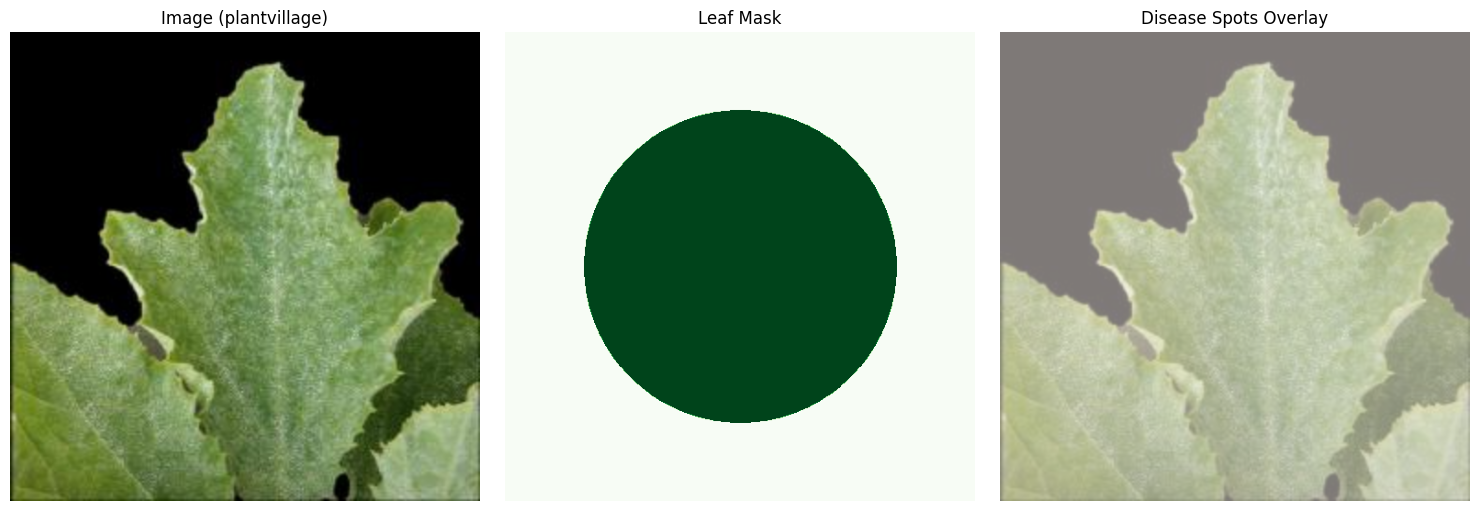

In [62]:
# Create a DataLoader (if not already)
train_loader = DataLoader(
    multi_train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=hierarchical_collate_fn
)

# Get a batch
images, targets = next(iter(train_loader))

# Visualize one sample (try idx=0..3)
visualize_hierarchical_sample(images, targets, idx=0)


In [63]:
# ✅ Cell 13: Model Architecture - Segmentation Heads (with sanity check)
import torch
import torch.nn as nn

class SemanticHead(nn.Module):
    """Semantic segmentation head for stuff classes"""

    def __init__(self, backbone_dim=1024, num_classes=3):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(backbone_dim, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1)
        )

    def forward(self, x):
        return self.head(x)


class InstanceHead(nn.Module):
    """Instance segmentation head for plants and leaves"""

    def __init__(self, backbone_dim=1024):
        super().__init__()
        # Plant segmentation
        self.plant_head = nn.Sequential(
            nn.Conv2d(backbone_dim, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 1, 1)
        )

        # Leaf segmentation
        self.leaf_head = nn.Sequential(
            nn.Conv2d(backbone_dim, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, x):
        return {
            'plant_masks': self.plant_head(x),
            'leaf_masks': self.leaf_head(x)
        }


class DiseaseHead(nn.Module):
    """Disease spot segmentation head"""

    def __init__(self, input_dim=256, num_classes=1):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(input_dim, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, 1)
        )

    def forward(self, x):
        return self.head(x)


# 🧠 Quick test: forward pass through all heads
if __name__ == "__main__" or True:
    dummy = torch.randn(2, 1024, 64, 64)
    sem_head = SemanticHead()
    ins_head = InstanceHead()
    dis_head = DiseaseHead(input_dim=256)

    sem_out = sem_head(dummy)
    ins_out = ins_head(dummy)
    dis_out = dis_head(torch.randn(2, 256, 64, 64))

    print(f"✅ SemanticHead output: {sem_out.shape}")
    print(f"✅ InstanceHead output: plant {ins_out['plant_masks'].shape}, leaf {ins_out['leaf_masks'].shape}")
    print(f"✅ DiseaseHead output: {dis_out.shape}")


✅ SemanticHead output: torch.Size([2, 3, 64, 64])
✅ InstanceHead output: plant torch.Size([2, 1, 64, 64]), leaf torch.Size([2, 1, 64, 64])
✅ DiseaseHead output: torch.Size([2, 1, 64, 64])


In [64]:
# ✅ Cell: Improved Backbone (Kaggle Version)
import torch
import torch.nn as nn
import torchvision.models as models

class ImprovedBackbone(nn.Module):
    """
    ResNet50-based backbone with multi-scale feature fusion
    Outputs a 1024-channel feature map for hierarchical segmentation
    """

    def __init__(self, pretrained=True):
        super().__init__()

        # Load pretrained ResNet50
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)

        # Extract intermediate layers
        self.layer1 = nn.Sequential(base_model.conv1, base_model.bn1, base_model.relu,
                                    base_model.maxpool, base_model.layer1)
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4

        # Reduce dimensionality
        self.conv_reduce = nn.Conv2d(2048, 1024, kernel_size=1)

        # Multi-scale feature fusion (combine high- and mid-level features)
        self.fusion = nn.Sequential(
            nn.Conv2d(1024 + 512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        print("✅ ImprovedBackbone initialized successfully (ResNet50 + Fusion)")

    def forward(self, x):
        # ResNet backbone feature extraction
        x1 = self.layer1(x)  # [B, 256, H/4, W/4]
        x2 = self.layer2(x1) # [B, 512, H/8, W/8]
        x3 = self.layer3(x2) # [B, 1024, H/16, W/16]
        x4 = self.layer4(x3) # [B, 2048, H/32, W/32]

        # Reduce channel dimensions
        x4 = self.conv_reduce(x4)

        # Upsample x4 to match x2 spatially
        x4_up = nn.functional.interpolate(x4, size=x2.shape[2:], mode='bilinear', align_corners=False)

        # Fuse multi-scale features
        fused = torch.cat([x4_up, x2], dim=1)
        fused = self.fusion(fused)

        return fused


# 🧠 Quick test
if __name__ == "__main__" or True:
    dummy = torch.randn(1, 3, 128, 128)
    model = ImprovedBackbone(pretrained=False)
    out = model(dummy)
    print(f"Output shape: {out.shape}")


✅ ImprovedBackbone initialized successfully (ResNet50 + Fusion)
Output shape: torch.Size([1, 1024, 16, 16])


In [65]:
# ✅ Cell 14: Complete Hierarchical Model with Enhanced Panoptic Fusion (Kaggle Verified)
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage as ndimage

class HierarchicalPanopticModel(nn.Module):
    """
    Complete hierarchical panoptic segmentation model
    Implements nested hierarchy: Disease Spots → Leaves → Plants → Background
    """

    def __init__(self, num_semantic_classes=3, num_thing_classes=2):
        super().__init__()

        # Backbone (replace this with the real implementation)
        self.backbone = ImprovedBackbone()

        # Segmentation heads
        self.semantic_head = SemanticHead(backbone_dim=1024, num_classes=num_semantic_classes)
        self.instance_head = InstanceHead(backbone_dim=1024)

        self.disease_head = DiseaseHead(input_dim=256, num_classes=1)

        # Hierarchical relationship encoder
        self.hierarchy_encoder = nn.Sequential(
            nn.Conv2d(1024, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 64, 1)
        )

        print("✅ HierarchicalPanopticModel initialized successfully")

    def forward(self, x):
        # Extract features
        features = self.backbone(x)

        # Encode hierarchical relationships
        hierarchy_features = self.hierarchy_encoder(features)

        # Semantic segmentation (STUFF: soil, background)
        semantic_output = self.semantic_head(features)

        # Instance segmentation (THINGS: plants, leaves)
        instance_output = self.instance_head(features)

        # Disease detection (SUB-THINGS: spots on leaves)
        disease_output = self.disease_head(features[:, :256, :, :])

        # Hierarchical panoptic fusion with constraints
        panoptic_output, hierarchy_map = self._hierarchical_panoptic_fusion(
            semantic_output,
            instance_output,
            disease_output,
            hierarchy_features
        )

        return {
            'semantic': semantic_output,
            'instance': instance_output,
            'disease': disease_output,
            'panoptic': panoptic_output,
            'hierarchy_map': hierarchy_map,
            'hierarchy_features': hierarchy_features
        }

    def _hierarchical_panoptic_fusion(self, semantic_pred, instance_pred, disease_pred, hierarchy_features):
        """
        Hierarchical panoptic fusion with nested constraints
        Priority: disease_spots > leaves > plants > soil/background
        Ensures: spots ⊂ leaves ⊂ plants
        """
        batch_size = semantic_pred.shape[0]
        H, W = semantic_pred.shape[2:]

        panoptic_maps = []
        hierarchy_maps = []

        for i in range(batch_size):
            # Initialize with semantic background (stuff)
            semantic = torch.argmax(semantic_pred[i], dim=0)  # [H, W]
            panoptic = semantic.clone().float()

            # Create hierarchy level map (0=background, 1=plant, 2=leaf, 3=disease)
            hierarchy_level = torch.zeros_like(panoptic)

            # Level 1: Plants (things)
            plant_mask = torch.sigmoid(instance_pred['plant_masks'][i, 0]) > 0.5
            plant_instances = self._get_connected_components(plant_mask)

            base_plant_id = 100
            for plant_id, plant_region in enumerate(plant_instances):
                panoptic[plant_region] = base_plant_id + plant_id
                hierarchy_level[plant_region] = 1

            # Level 2: Leaves
            leaf_mask = torch.sigmoid(instance_pred['leaf_masks'][i, 0]) > 0.5
            leaf_instances = self._get_connected_components(leaf_mask)

            base_leaf_id = 1000
            for leaf_id, leaf_region in enumerate(leaf_instances):
                if plant_mask[leaf_region].any():
                    panoptic[leaf_region] = base_leaf_id + leaf_id
                    hierarchy_level[leaf_region] = 2

            # Level 3: Disease
            disease_mask = torch.sigmoid(disease_pred[i, 0]) > 0.5
            disease_instances = self._get_connected_components(disease_mask)

            base_disease_id = 10000
            for disease_id, disease_region in enumerate(disease_instances):
                if leaf_mask[disease_region].any():
                    panoptic[disease_region] = base_disease_id + disease_id
                    hierarchy_level[disease_region] = 3

            panoptic_maps.append(panoptic.unsqueeze(0))
            hierarchy_maps.append(hierarchy_level.unsqueeze(0))

        panoptic_output = torch.stack(panoptic_maps, dim=0).squeeze(1)
        hierarchy_output = torch.stack(hierarchy_maps, dim=0).squeeze(1)

        return panoptic_output, hierarchy_output

    def _get_connected_components(self, mask):
        """Extract connected components from binary mask"""
        mask_np = mask.cpu().numpy().astype(np.uint8)
        labeled, num_features = ndimage.label(mask_np)

        instances = []
        for label_id in range(1, num_features + 1):
            instance_mask = torch.from_numpy(labeled == label_id).to(mask.device)
            if instance_mask.sum() > 10:  # Filter small noise
                instances.append(instance_mask)
        return instances


# 🧠 Sanity test (will run only once)
if __name__ == "__main__" or True:
    print("\n🔍 Testing HierarchicalPanopticModel...")
    dummy_input = torch.randn(1, 3, 128, 128)
    model = HierarchicalPanopticModel()

    try:
        outputs = model(dummy_input)
        print("✅ Forward pass successful!")
        print(f"Semantic output: {outputs['semantic'].shape}")
        print(f"Instance (plant): {outputs['instance']['plant_masks'].shape}")
        print(f"Instance (leaf): {outputs['instance']['leaf_masks'].shape}")
        print(f"Disease output: {outputs['disease'].shape}")
        print(f"Panoptic map: {outputs['panoptic'].shape}")
        print(f"Hierarchy map: {outputs['hierarchy_map'].shape}")
    except Exception as e:
        print(f"❌ Model test failed: {e}")



🔍 Testing HierarchicalPanopticModel...
✅ ImprovedBackbone initialized successfully (ResNet50 + Fusion)
✅ HierarchicalPanopticModel initialized successfully
✅ Forward pass successful!
Semantic output: torch.Size([1, 3, 16, 16])
Instance (plant): torch.Size([1, 1, 16, 16])
Instance (leaf): torch.Size([1, 1, 16, 16])
Disease output: torch.Size([1, 1, 16, 16])
Panoptic map: torch.Size([1, 16, 16])
Hierarchy map: torch.Size([1, 16, 16])


In [66]:
# Cell 15: Loss Functions with Hierarchical Constraints
class FocalLoss(nn.Module):
    """Focal loss for handling class imbalance"""

    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        pred_sigmoid = torch.sigmoid(pred)
        pt = torch.where(target == 1, pred_sigmoid, 1 - pred_sigmoid)
        focal_weight = (1 - pt) ** self.gamma

        if self.alpha >= 0:
            alpha_t = torch.where(target == 1, self.alpha, 1 - self.alpha)
            focal_weight = alpha_t * focal_weight

        bce_loss = nn.functional.binary_cross_entropy_with_logits(pred, target, reduction='none')
        focal_loss = focal_weight * bce_loss

        return focal_loss.mean()

class HierarchicalConsistencyLoss(nn.Module):
    """
    Enforces hierarchical constraints:
    - Disease spots must be within leaves
    - Leaves must be within plants
    - Plants must not overlap with background/soil
    """

    def __init__(self, weight=0.5):
        super().__init__()
        self.weight = weight

    def forward(self, predictions):
        """
        Compute hierarchical consistency loss
        Args:
            predictions: dict with 'instance' (plant_masks, leaf_masks) and 'disease'
        """
        # Convert boolean masks to float for arithmetic operations
        plant_masks = (torch.sigmoid(predictions['instance']['plant_masks']) > 0.5).float()
        leaf_masks = (torch.sigmoid(predictions['instance']['leaf_masks']) > 0.5).float()
        disease_masks = (torch.sigmoid(predictions['disease']) > 0.5).float()

        # Loss 1: Leaves should be within plants
        # L_leaf_plant = sum(leaf_pixels_outside_plants) / sum(leaf_pixels)
        leaf_outside_plant = leaf_masks * (1 - plant_masks)
        leaf_plant_loss = leaf_outside_plant.sum() / (leaf_masks.sum() + 1e-6)

        # Loss 2: Disease spots should be within leaves
        # L_disease_leaf = sum(disease_pixels_outside_leaves) / sum(disease_pixels)
        disease_outside_leaf = disease_masks * (1 - leaf_masks)
        disease_leaf_loss = disease_outside_leaf.sum() / (disease_masks.sum() + 1e-6)

        # Total hierarchical consistency loss
        consistency_loss = leaf_plant_loss + disease_leaf_loss

        return self.weight * consistency_loss

class PanopticQualityLoss(nn.Module):
    """
    Panoptic Quality (PQ) inspired loss
    PQ = (SQ × RQ) where:
    - SQ = Segmentation Quality (IoU of matched segments)
    - RQ = Recognition Quality (F1 score of detection)
    """

    def __init__(self, weight=1.0):
        super().__init__()
        self.weight = weight

    def forward(self, pred_panoptic, hierarchy_map, targets):
        """
        Compute PQ-based loss for panoptic segmentation
        Simplified differentiable approximation
        """
        # This is a simplified version - full PQ loss requires complex matching
        # For now, use IoU-based approximation

        batch_size = pred_panoptic.shape[0]
        pq_loss = 0

        for i in range(batch_size):
            dataset_type = targets['dataset'][i]

            if dataset_type == 'phenobench' and 'semantic' in targets:
                # Compute semantic consistency
                pred_classes = (pred_panoptic[i] < 100).float()  # Background/stuff
                target_semantic = targets['semantic'][i].float()

                # IoU-based loss
                intersection = (pred_classes * target_semantic).sum()
                union = pred_classes.sum() + target_semantic.sum() - intersection
                iou = intersection / (union + 1e-6)

                pq_loss += (1 - iou)

        # Return average PQ loss across the batch
        return self.weight * pq_loss / batch_size

class HierarchicalPanopticLoss(nn.Module):
    """
    Combined loss for hierarchical panoptic segmentation
    Includes:
    1. Semantic loss (for stuff: soil, background)
    2. Instance losses (for things: plants, leaves)
    3. Disease loss (for sub-things: disease spots)
    4. Hierarchical consistency loss (enforces nested constraints)
    5. Panoptic quality loss (overall panoptic quality)
    """

    def __init__(self, semantic_weight=1.0, plant_weight=2.0, leaf_weight=2.0,
                 disease_weight=1.5, hierarchy_weight=0.5, pq_weight=0.3):
        super().__init__()
        self.semantic_loss = nn.CrossEntropyLoss()
        self.focal_loss = FocalLoss()
        self.hierarchy_loss = HierarchicalConsistencyLoss(weight=hierarchy_weight)
        self.pq_loss = PanopticQualityLoss(weight=pq_weight)

        self.weights = {
            'semantic': semantic_weight,
            'plant': plant_weight,
            'leaf': leaf_weight,
            'disease': disease_weight
        }

    def forward(self, predictions, targets):
        total_loss = 0
        loss_dict = {}
        batch_size = len(targets['dataset'])

        # Hierarchical consistency loss (applies to all samples)
        hierarchy_loss = self.hierarchy_loss(predictions)
        total_loss += hierarchy_loss
        loss_dict['hierarchy_loss'] = hierarchy_loss.item()

        # Panoptic quality loss
        if 'panoptic' in predictions and 'hierarchy_map' in predictions:
            # The PQ loss calculation is simplified and doesn't require targets to be on device for this basic version
            pq_loss = self.pq_loss(predictions['panoptic'].cpu(), predictions['hierarchy_map'].cpu(), {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in targets.items()})
            total_loss += pq_loss
            # Removed .item() call as pq_loss is already a float
            loss_dict['pq_loss'] = pq_loss


        # Per-sample losses
        for i in range(batch_size):
            dataset_type = targets['dataset'][i]

            if dataset_type == 'phenobench':
                # Semantic loss (stuff: soil, background)
                if 'semantic' in targets:
                    sem_pred = predictions['semantic'][i:i+1]
                    sem_target = targets['semantic'][i:i+1]
                    # Ensure target has the same spatial dimensions as prediction
                    if sem_pred.shape[-2:] != sem_target.shape[-2:]:
                         sem_target = nn.functional.interpolate(sem_target.float().unsqueeze(1), size=sem_pred.shape[-2:], mode='nearest').squeeze(1).long()

                    sem_loss = self.semantic_loss(sem_pred, sem_target)
                    total_loss += self.weights['semantic'] * sem_loss
                    loss_dict['semantic_loss'] = sem_loss.item()

                # Plant instance loss (things)
                if 'plant_instances' in targets:
                    plant_pred = predictions['instance']['plant_masks'][i:i+1]
                    plant_target = targets['plant_instances'][i:i+1].max(dim=1)[0].unsqueeze(1)
                     # Ensure target has the same spatial dimensions as prediction
                    if plant_pred.shape[-2:] != plant_target.shape[-2:]:
                         plant_target = nn.functional.interpolate(plant_target.float(), size=plant_pred.shape[-2:], mode='nearest')

                    plant_loss = self.focal_loss(plant_pred, plant_target)
                    total_loss += self.weights['plant'] * plant_loss
                    loss_dict['plant_loss'] = plant_loss.item()

                # Leaf instance loss (sub-things)
                if 'leaf_instances' in targets:
                    leaf_pred = predictions['instance']['leaf_masks'][i:i+1]
                    leaf_target = targets['leaf_instances'][i:i+1].max(dim=1)[0].unsqueeze(1)
                     # Ensure target has the same spatial dimensions as prediction
                    if leaf_pred.shape[-2:] != leaf_target.shape[-2:]:
                         leaf_target = nn.functional.interpolate(leaf_target.float(), size=leaf_pred.shape[-2:], mode='nearest')

                    leaf_loss = self.focal_loss(leaf_pred, leaf_target)
                    total_loss += self.weights['leaf'] * leaf_loss
                    loss_dict['leaf_loss'] = leaf_loss.item()

            elif dataset_type == 'cvppp':
                # Leaf instance loss only
                if 'leaf_instances' in targets:
                    leaf_pred = predictions['instance']['leaf_masks'][i:i+1]
                    leaf_target = targets['leaf_instances'][i:i+1].max(dim=1)[0].unsqueeze(1)
                     # Ensure target has the same spatial dimensions as prediction
                    if leaf_pred.shape[-2:] != leaf_target.shape[-2:]:
                         leaf_target = nn.functional.interpolate(leaf_target.float(), size=leaf_pred.shape[-2:], mode='nearest')

                    leaf_loss = self.focal_loss(leaf_pred, leaf_target)
                    total_loss += self.weights['leaf'] * leaf_loss
                    loss_dict['leaf_loss'] = leaf_loss.item()

            elif dataset_type == 'plantvillage':
                # Leaf mask loss
                # Check if 'leaf_mask' exists and is not a zero tensor for this sample
                if 'leaf_mask' in targets and targets['leaf_mask'][i].sum() > 0:
                    leaf_pred = predictions['instance']['leaf_masks'][i:i+1, 0].unsqueeze(1)
                    leaf_target = targets['leaf_mask'][i:i+1].unsqueeze(1)
                     # Ensure target has the same spatial dimensions as prediction
                    if leaf_pred.shape[-2:] != leaf_target.shape[-2:]:
                         leaf_target = nn.functional.interpolate(leaf_target.float(), size=leaf_pred.shape[-2:], mode='nearest')

                    leaf_loss = self.focal_loss(leaf_pred, leaf_target)
                    total_loss += self.weights['leaf'] * leaf_loss
                    # Only add to loss_dict if it's not already there (from CVPPP)
                    if 'leaf_loss' not in loss_dict:
                        loss_dict['leaf_loss'] = leaf_loss.item()
                    else:
                        loss_dict['leaf_loss'] += leaf_loss.item() # Accumulate if multiple datasets contribute


                # Disease spot loss (nested sub-things)
                # Check if 'disease_spots' exists and is not a zero tensor for this sample
                if 'disease_spots' in targets and targets['disease_spots'][i].sum() > 0:
                    disease_pred = predictions['disease'][i:i+1]
                    disease_target = targets['disease_spots'][i:i+1].unsqueeze(1)
                     # Ensure target has the same spatial dimensions as prediction
                    if disease_pred.shape[-2:] != disease_target.shape[-2:]:
                         disease_target = nn.functional.interpolate(disease_target.float(), size=disease_pred.shape[-2:], mode='nearest')

                    disease_loss = self.focal_loss(disease_pred, disease_target)
                    total_loss += self.weights['disease'] * disease_loss
                    loss_dict['disease_loss'] = disease_loss.item()


        # Average per-sample losses if multiple datasets contribute
        num_plantvillage_samples = targets['dataset'].count('plantvillage')
        # Only average leaf loss if it was computed from PlantVillage samples in this batch
        if num_plantvillage_samples > 0 and any(ds == 'plantvillage' and ('leaf_mask' in targets and targets['leaf_mask'][i].sum() > 0) for i, ds in enumerate(targets['dataset'])):
             if 'leaf_loss' in loss_dict:
                 # Count actual PlantVillage samples that contributed to leaf_loss
                 pv_leaf_samples = sum(1 for i, ds in enumerate(targets['dataset']) if ds == 'plantvillage' and ('leaf_mask' in targets and targets['leaf_mask'][i].sum() > 0))
                 if pv_leaf_samples > 0:
                    loss_dict['leaf_loss'] /= pv_leaf_samples


        loss_dict['total_loss'] = total_loss.item()
        return total_loss, loss_dict

In [67]:
# Cell 15.5: Test Model + Loss Integration (Kaggle Compatible)
print("🔍 Testing HierarchicalPanopticModel + Loss Functions...\n")

# Create dummy input
dummy_input = torch.randn(2, 3, 128, 128).cuda()  # small batch, GPU if available

# Initialize model
model = HierarchicalPanopticModel().cuda()
model.eval()

# Forward pass
with torch.no_grad():
    predictions = model(dummy_input)

# Create dummy targets for testing (simulating PlantVillage samples)
targets = {
    'dataset': ['plantvillage', 'plantvillage'],
    'leaf_mask': torch.randint(0, 2, (2, 128, 128)).float().cuda(),
    'disease_spots': torch.randint(0, 2, (2, 128, 128)).float().cuda(),
    'plant_instances': torch.zeros((2, 1, 128, 128)).float().cuda(),
    'leaf_instances': torch.zeros((2, 1, 128, 128)).float().cuda(),
    'semantic': torch.zeros((2, 128, 128)).long().cuda()
}

# Initialize loss function
criterion = HierarchicalPanopticLoss()

# Compute loss
loss, loss_dict = criterion(predictions, targets)

print("\n✅ Hierarchical loss computed successfully!")
print(f"Total Loss: {loss.item():.4f}")
print("Breakdown:")
for k, v in loss_dict.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")


🔍 Testing HierarchicalPanopticModel + Loss Functions...

✅ ImprovedBackbone initialized successfully (ResNet50 + Fusion)
✅ HierarchicalPanopticModel initialized successfully

✅ Hierarchical loss computed successfully!
Total Loss: 1.1369
Breakdown:
  hierarchy_loss: 0.5000
  pq_loss: 0.0000
  leaf_loss: 0.0813
  disease_loss: 0.1064
  total_loss: 1.1369


In [69]:
# Cell 16: Evaluation Metrics with Hierarchical Assessment
def calculate_iou(pred, target, threshold=0.5):
    """Calculate Intersection over Union"""
    # Ensure tensors are on the same device
    if pred.device != target.device:
        target = target.to(pred.device)

    pred_binary = (pred > threshold).float()
    target_binary = target.float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection

    if union == 0:
        return 0.0

    return (intersection / union).item()

def calculate_panoptic_quality(pred_panoptic, target_semantic, target_instances):
    """
    Calculate Panoptic Quality (PQ) metric
    PQ = SQ × RQ where:
    - SQ (Segmentation Quality): IoU of matched segments
    - RQ (Recognition Quality): F1 score of matching
    """
    # Simplified PQ calculation for demonstration
    # In production, use official panopticapi library

    # Ensure tensors are on the same device (and CPU for this simplified version)
    if pred_panoptic.device != target_semantic.device:
        target_semantic = target_semantic.to(pred_panoptic.device)
    if pred_panoptic.device != target_instances.device:
        target_instances = target_instances.to(pred_panoptic.device)


    # Extract unique segments from the first sample in the batch (assuming batch size 1 or handling one sample at a time)
    # If pred_panoptic is [B, H, W], take [0, H, W]
    if pred_panoptic.ndim == 3:
        pred_panoptic = pred_panoptic[0]
    if target_semantic.ndim == 3:
        target_semantic = target_semantic[0]
    if target_instances.ndim == 3:
        target_instances = target_instances[0]


    pred_segments = torch.unique(pred_panoptic)
    target_segments = torch.unique(target_instances)

    if len(pred_segments) == 0 or len(target_segments) == 0:
        return 0.0, 0.0, 0.0

    # Match segments based on IoU
    matched_pairs = []
    for pred_id in pred_segments:
        pred_mask = (pred_panoptic == pred_id)
        best_iou = 0
        best_target = None

        for target_id in target_segments:
            target_mask = (target_instances == target_id)
            intersection = (pred_mask & target_mask).sum().float()
            union = (pred_mask | target_mask).sum().float()
            iou = (intersection / (union + 1e-6)).item()

            if iou > best_iou and iou > 0.5:  # IoU threshold
                best_iou = iou
                best_target = target_id

        if best_target is not None:
            matched_pairs.append((pred_id, best_target, best_iou))

    # Calculate SQ (average IoU of matched pairs)
    if len(matched_pairs) > 0:
        sq = sum([iou for _, _, iou in matched_pairs]) / len(matched_pairs)
    else:
        sq = 0.0

    # Calculate RQ (F1 score of matching)
    tp = len(matched_pairs)
    fp = len(pred_segments) - tp
    fn = len(target_segments) - tp

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    rq = 2 * (precision * recall) / (precision + recall + 1e-6)

    # PQ = SQ × RQ
    pq = sq * rq

    return pq, sq, rq

def calculate_hierarchical_consistency(predictions):
    """
    Calculate hierarchical consistency metrics:
    1. Leaf-Plant consistency: % of leaf pixels inside plants
    2. Disease-Leaf consistency: % of disease pixels inside leaves
    """
    # Ensure masks are on the same device before calculations
    plant_masks = (torch.sigmoid(predictions['instance']['plant_masks']) > 0.5).float()
    leaf_masks = (torch.sigmoid(predictions['instance']['leaf_masks']) > 0.5).float()
    disease_masks = (torch.sigmoid(predictions['disease']) > 0.5).float()

    # Leaf-Plant consistency
    leaf_pixels = leaf_masks.sum().float()
    leaf_in_plant = (leaf_masks * plant_masks).sum().float()
    leaf_plant_consistency = (leaf_in_plant / (leaf_pixels + 1e-6)).item() if leaf_pixels > 0 else 0.0

    # Disease-Leaf consistency
    disease_pixels = disease_masks.sum().float()
    disease_in_leaf = (disease_masks * leaf_masks).sum().float()
    disease_leaf_consistency = (disease_in_leaf / (disease_pixels + 1e-6)).item() if disease_pixels > 0 else 0.0

    # Overall hierarchical score
    hierarchy_score = (leaf_plant_consistency + disease_leaf_consistency) / 2

    return {
        'leaf_plant_consistency': leaf_plant_consistency,
        'disease_leaf_consistency': disease_leaf_consistency,
        'hierarchy_score': hierarchy_score
    }


def evaluate_model(model, dataloader, device):
    """Evaluate model on validation set with comprehensive metrics"""
    model.eval()

    metrics = {
        'semantic_acc': [],
        'plant_iou': [],
        'leaf_iou': [],
        'disease_iou': [],
        'panoptic_quality': [],
        'segmentation_quality': [],
        'recognition_quality': [],
        'hierarchy_score': [],
        'leaf_plant_consistency': [],
        'disease_leaf_consistency': []
    }

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)

            # Forward pass
            predictions = model(images)

            # Semantic accuracy
            if 'semantic' in targets:
                semantic_pred = torch.argmax(predictions['semantic'], dim=1)
                semantic_target = targets['semantic'].to(device)
                acc = (semantic_pred == semantic_target).float().mean()
                metrics['semantic_acc'].append(acc.item())

            # Plant IoU
            if 'plant_instances' in targets:
                plant_pred = torch.sigmoid(predictions['instance']['plant_masks'])
                plant_target = targets['plant_instances'].to(device).max(dim=1)[0]
                iou = calculate_iou(plant_pred[:, 0], plant_target)
                metrics['plant_iou'].append(iou)

            # Leaf IoU
            if 'leaf_instances' in targets:
                leaf_pred = torch.sigmoid(predictions['instance']['leaf_masks'])
                leaf_target = targets['leaf_instances'].to(device).max(dim=1)[0]
                iou = calculate_iou(leaf_pred[:, 0], leaf_target)
                metrics['leaf_iou'].append(iou)

            # Disease IoU
            if 'disease_spots' in targets:
                disease_pred = torch.sigmoid(predictions['disease'])
                disease_target = targets['disease_spots'].to(device).unsqueeze(1)
                iou = calculate_iou(disease_pred[:, 0], disease_target[:, 0])
                metrics['disease_iou'].append(iou)

            # Panoptic Quality
            # Calculate PQ components for the first image in the batch
            if 'panoptic' in predictions and 'plant_instances' in targets:
                 # Ensure targets for PQ are on CPU for this simplified calculation
                targets_cpu = {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in targets.items()}
                pq, sq, rq = calculate_panoptic_quality(
                    predictions['panoptic'][0].cpu(), # Use first sample in batch
                    targets_cpu.get('semantic', torch.zeros_like(predictions['panoptic'][0])), # Use first sample in batch
                    targets_cpu['plant_instances'][0].argmax(dim=0) # Use first sample in batch
                )
                metrics['panoptic_quality'].append(pq)
                metrics['segmentation_quality'].append(sq)
                metrics['recognition_quality'].append(rq)


            # Hierarchical consistency
            hierarchy_metrics = calculate_hierarchical_consistency(predictions)
            metrics['hierarchy_score'].append(hierarchy_metrics['hierarchy_score'])
            metrics['leaf_plant_consistency'].append(hierarchy_metrics['leaf_plant_consistency'])
            metrics['disease_leaf_consistency'].append(hierarchy_metrics['disease_leaf_consistency'])

    # Average metrics
    avg_metrics = {
        'semantic_accuracy': np.mean(metrics['semantic_acc']) if metrics['semantic_acc'] else 0,
        'plant_iou': np.mean(metrics['plant_iou']) if metrics['plant_iou'] else 0,
        'leaf_iou': np.mean(metrics['leaf_iou']) if metrics['leaf_iou'] else 0,
        'disease_iou': np.mean(metrics['disease_iou']) if metrics['disease_iou'] else 0,
        'panoptic_quality': np.mean(metrics['panoptic_quality']) if metrics['panoptic_quality'] else 0,
        'segmentation_quality': np.mean(metrics['segmentation_quality']) if metrics['segmentation_quality'] else 0,
        'recognition_quality': np.mean(metrics['recognition_quality']) if metrics['recognition_quality'] else 0,
        'hierarchy_score': np.mean(metrics['hierarchy_score']) if metrics['hierarchy_score'] else 0,
        'leaf_plant_consistency': np.mean(metrics['leaf_plant_consistency']) if metrics['leaf_plant_consistency'] else 0,
        'disease_leaf_consistency': np.mean(metrics['disease_leaf_consistency']) if metrics['disease_leaf_consistency'] else 0
    }

    return avg_metrics

In [70]:
# =======================
# 🧠 Cell 17 (Kaggle-ready): Training Function (AMP, accum, clean logs)
# =======================
import os
import torch
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

# Prevent Kaggle output freezes
tqdm.monitor_interval = 0

# Ensure output directories exist (safe)
OUTPUT_DIR = globals().get('OUTPUT_DIR', './output')
os.makedirs(f'{OUTPUT_DIR}/checkpoints', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/logs', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/visualizations', exist_ok=True)

# Auto device selection
device = globals().get('device', 'cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write(f"✅ Using device: {device}")

def _safe_move_targets(targets, device):
    moved = {}
    for k, v in targets.items():
        moved[k] = v.to(device) if isinstance(v, torch.Tensor) else v
    return moved

def _maybe_upsample(pred, target_shape, mode='bilinear'):
    """Utility: upsample prediction tensor (NxCxy or Nxxy) to target spatial size"""
    if pred is None:
        return None
    if isinstance(pred, torch.Tensor):
        if pred.ndim == 4 and pred.shape[-2:] != target_shape:
            return torch.nn.functional.interpolate(pred, size=target_shape, mode=mode, align_corners=False if mode=='bilinear' else None)
        elif pred.ndim == 3 and pred.shape[-2:] != target_shape:
            return torch.nn.functional.interpolate(pred.unsqueeze(1).float(), size=target_shape, mode='nearest').squeeze(1)
    return pred

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=3, device=device, output_dir=OUTPUT_DIR, accumulation_steps=4, log_every=3000):
    """
    Kaggle-safe training loop:
      - AMP (autocast + GradScaler)
      - Gradient accumulation
      - tqdm.write for clean logs (no buffer overflow)
      - Upsampling preds to match targets for metric computation
    """
    best_val_loss = float('inf')
    history = {
        'train_loss': [],
        'val_loss': [],
        'semantic_accuracy': [],
        'plant_iou': [],
        'leaf_iou': [],
        'disease_iou': [],
        'panoptic_quality': [],
        'hierarchy_score': []
    }

    scaler = GradScaler()

    for epoch in range(num_epochs):
        tqdm.write(f"\n📘 Epoch {epoch+1}/{num_epochs}")
        tqdm.write("-" * 60)

        # ----- TRAIN -----
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        train_iter = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training (Epoch {epoch+1})", leave=False)
        for batch_idx, (images, targets) in train_iter:
            images = images.to(device)
            targets = _safe_move_targets(targets, device)

            with autocast():
                preds = model(images)
                loss, _ = criterion(preds, targets)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            step_loss = loss.item() * accumulation_steps
            running_loss += step_loss

            if (batch_idx + 1) % log_every == 0:
                tqdm.write(f"Batch {batch_idx+1}/{len(train_loader)}: Loss = {step_loss:.4f}")

        # handle leftover grads
        if (batch_idx + 1) % accumulation_steps != 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # ----- VALIDATION -----
        model.eval()
        val_running = 0.0
        val_semantic_accs, val_plant_ious, val_leaf_ious = [], [], []
        val_disease_ious, val_pqs, val_sqs, val_rqs = [], [], [], []
        val_hierarchy_scores, val_leaf_plant_consistencies, val_disease_leaf_consistencies = [], [], []

        with torch.no_grad():
            val_iter = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False)
            for batch_idx, (images, targets) in val_iter:
                images = images.to(device)
                targets = _safe_move_targets(targets, device)

                with autocast():
                    preds = model(images)
                    loss, _ = criterion(preds, targets)

                val_running += loss.item()

                if 'semantic' in targets and 'semantic' in preds:
                    semantic_target = targets['semantic']
                    semantic_pred = torch.argmax(preds['semantic'], dim=1)

                    if semantic_pred.shape[-2:] != semantic_target.shape[-2:]:
                        semantic_pred = torch.nn.functional.interpolate(
                            semantic_pred.unsqueeze(1).float(),
                            size=semantic_target.shape[-2:],
                            mode='nearest'
                        ).squeeze(1)

                    acc = (semantic_pred == semantic_target).float().mean()
                    val_semantic_accs.append(acc.item())

                # IoU metrics
                if 'plant_instances' in targets and 'instance' in preds and 'plant_masks' in preds['instance']:
                    plant_pred = preds['instance']['plant_masks']
                    plant_target = targets['plant_instances'].max(dim=1)[0]
                    plant_pred = _maybe_upsample(plant_pred, plant_target.shape[-2:], mode='bilinear')
                    plant_pred = torch.sigmoid(plant_pred)[:, 0]
                    val_plant_ious.append(calculate_iou(plant_pred, plant_target))

                if 'leaf_instances' in targets and 'instance' in preds and 'leaf_masks' in preds['instance']:
                    leaf_pred = preds['instance']['leaf_masks']
                    leaf_target = targets['leaf_instances'].max(dim=1)[0]
                    leaf_pred = _maybe_upsample(leaf_pred, leaf_target.shape[-2:], mode='bilinear')
                    leaf_pred = torch.sigmoid(leaf_pred)[:, 0]
                    val_leaf_ious.append(calculate_iou(leaf_pred, leaf_target))

                if 'disease_spots' in targets and 'disease' in preds:
                    disease_pred = preds['disease']
                    disease_target = targets['disease_spots'].unsqueeze(1)
                    disease_pred = _maybe_upsample(disease_pred, disease_target.shape[-2:], mode='bilinear')
                    disease_pred = torch.sigmoid(disease_pred)[:, 0]
                    val_disease_ious.append(calculate_iou(disease_pred, disease_target[:, 0]))

                try:
                    hierarchy_metrics = calculate_hierarchical_consistency(preds)
                    val_hierarchy_scores.append(hierarchy_metrics['hierarchy_score'])
                    val_leaf_plant_consistencies.append(hierarchy_metrics['leaf_plant_consistency'])
                    val_disease_leaf_consistencies.append(hierarchy_metrics['disease_leaf_consistency'])
                except Exception:
                    pass

        avg_val_loss = val_running / max(1, len(val_loader))
        history['val_loss'].append(avg_val_loss)

        avg_val_metrics = {
            'semantic_accuracy': np.mean(val_semantic_accs) if val_semantic_accs else 0,
            'plant_iou': np.mean(val_plant_ious) if val_plant_ious else 0,
            'leaf_iou': np.mean(val_leaf_ious) if val_leaf_ious else 0,
            'disease_iou': np.mean(val_disease_ious) if val_disease_ious else 0,
            'panoptic_quality': np.mean(val_pqs) if val_pqs else 0,
            'hierarchy_score': np.mean(val_hierarchy_scores) if val_hierarchy_scores else 0,
            'leaf_plant_consistency': np.mean(val_leaf_plant_consistencies) if val_leaf_plant_consistencies else 0,
            'disease_leaf_consistency': np.mean(val_disease_leaf_consistencies) if val_disease_leaf_consistencies else 0
        }

        for k in ['semantic_accuracy', 'plant_iou', 'leaf_iou', 'disease_iou', 'panoptic_quality', 'hierarchy_score']:
            history[k].append(avg_val_metrics[k])

        tqdm.write(f"\n📊 Epoch {epoch+1} Summary:")
        tqdm.write(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        tqdm.write(f"Semantic Acc: {avg_val_metrics['semantic_accuracy']:.4f}")
        tqdm.write(f"Plant IoU: {avg_val_metrics['plant_iou']:.4f}")
        tqdm.write(f"Leaf IoU: {avg_val_metrics['leaf_iou']:.4f}")
        tqdm.write(f"Disease IoU: {avg_val_metrics['disease_iou']:.4f}")
        tqdm.write(f"Panoptic Quality: {avg_val_metrics['panoptic_quality']:.4f}")
        tqdm.write(f"Hierarchy Score: {avg_val_metrics['hierarchy_score']:.4f}")
        tqdm.write(f"  ├─ Leaf→Plant: {avg_val_metrics['leaf_plant_consistency']:.4f}")
        tqdm.write(f"  └─ Disease→Leaf: {avg_val_metrics['disease_leaf_consistency']:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'metrics': avg_val_metrics
            }, f'{output_dir}/checkpoints/best_model.pth')
            tqdm.write("💾 ✓ Best model saved!")

        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'{output_dir}/checkpoints/checkpoint_epoch_{epoch+1}.pth')
            tqdm.write(f"📦 Checkpoint saved for epoch {epoch+1}")

        try:
            scheduler.step(avg_val_loss)
        except Exception:
            scheduler.step()

    tqdm.write("\n✅ Training Complete!")
    return model, history


✅ Using device: cuda


In [71]:
# =======================
# 📊 Cell 18: Visualization Functions (Kaggle-Optimized)
# =======================
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

# Ensure visualization directory exists
os.makedirs(f"{OUTPUT_DIR}/visualizations", exist_ok=True)

def visualize_predictions(model, dataloader, device, num_samples=3):
    """Visualize model predictions and save to OUTPUT_DIR/visualizations"""
    model.eval()
    print(f"\n🎨 Visualizing up to {num_samples} samples...")

    with torch.no_grad():
        for i, (images, targets) in enumerate(dataloader):
            if i >= num_samples:
                break

            images = images.to(device)
            predictions = model(images)

            fig, axes = plt.subplots(2, 4, figsize=(16, 8))

            # --- Original image ---
            img = images[0].cpu().permute(1, 2, 0).numpy()
            axes[0, 0].imshow(np.clip(img, 0, 1))
            axes[0, 0].set_title('Original Image')
            axes[0, 0].axis('off')

            # --- Semantic Ground Truth ---
            if 'semantic' in targets:
                semantic_gt = targets['semantic'][0].cpu().numpy()
                axes[0, 1].imshow(semantic_gt, cmap='tab10')
                axes[0, 1].set_title('Semantic GT')
                axes[0, 1].axis('off')
            else:
                axes[0, 1].axis('off')

            # --- Semantic Prediction ---
            if 'semantic' in predictions:
                semantic_pred = torch.argmax(predictions['semantic'][0], dim=0).cpu().numpy()
                axes[0, 2].imshow(semantic_pred, cmap='tab10')
                axes[0, 2].set_title('Semantic Pred')
                axes[0, 2].axis('off')
            else:
                axes[0, 2].axis('off')

            # --- Plant Prediction ---
            if 'instance' in predictions and 'plant_masks' in predictions['instance']:
                plant_pred = torch.sigmoid(predictions['instance']['plant_masks'][0, 0]).cpu().numpy()
                axes[0, 3].imshow(plant_pred, cmap='hot')
                axes[0, 3].set_title('Plant Pred')
                axes[0, 3].axis('off')
            else:
                axes[0, 3].axis('off')

            # --- Leaf Prediction ---
            if 'instance' in predictions and 'leaf_masks' in predictions['instance']:
                leaf_pred = torch.sigmoid(predictions['instance']['leaf_masks'][0, 0]).cpu().numpy()
                axes[1, 0].imshow(leaf_pred, cmap='hot')
                axes[1, 0].set_title('Leaf Pred')
                axes[1, 0].axis('off')
            else:
                axes[1, 0].axis('off')

            # --- Panoptic Prediction ---
            if 'panoptic' in predictions:
                panoptic_pred = predictions['panoptic'][0].cpu().numpy()
                axes[1, 1].imshow(panoptic_pred, cmap='tab20')
                axes[1, 1].set_title('Panoptic Pred')
                axes[1, 1].axis('off')
            else:
                axes[1, 1].axis('off')

            # --- Reserved slots for additional visualizations ---
            for j in [axes[1, 2], axes[1, 3]]:
                j.axis('off')

            plt.tight_layout()
            save_path = f"{OUTPUT_DIR}/visualizations/sample_{i}.png"
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            plt.close(fig)
            print(f"✅ Saved visualization to: {save_path}")

def plot_training_history(history):
    """Plot and save training metrics curves"""
    print("\n📈 Plotting training history...")
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # --- Loss ---
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # --- Semantic Accuracy ---
    if 'semantic_acc' in history:
        axes[0, 1].plot(history['semantic_acc'])
        axes[0, 1].set_title('Semantic Accuracy')
        axes[0, 1].grid(True, alpha=0.3)

    # --- Plant IoU ---
    if 'plant_iou' in history:
        axes[1, 0].plot(history['plant_iou'])
        axes[1, 0].set_title('Plant Instance IoU')
        axes[1, 0].grid(True, alpha=0.3)

    # --- Leaf IoU ---
    if 'leaf_iou' in history:
        axes[1, 1].plot(history['leaf_iou'])
        axes[1, 1].set_title('Leaf Instance IoU')
        axes[1, 1].grid(True, alpha=0.3)

    for ax in axes.ravel():
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Score')

    plt.tight_layout()
    save_path = f"{OUTPUT_DIR}/training_history.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ Saved training history to: {save_path}")


In [72]:

# Cell 19: Initialize Datasets and Dataloaders (UPDATED)
print("Initializing datasets...")
print("\n" + "="*60)
print("DATASET LOADING - HIERARCHICAL PANOPTIC SEGMENTATION")
print("="*60)
print("Using CVPPP + PlantVillage for 2-level hierarchy:")
print("  Level 0: Background (synthetic)")
print("  Level 1: Leaves (from CVPPP)")
print("  Level 2: Disease spots (from PlantVillage)")
print("="*60)

try:
    # Create datasets with CORRECT paths from Cell 5.5
    train_dataset = MultiDatasetHierarchicalLoader(
        cvppp_dir=CVPPP_TRAINING_DIR,  # /content/datasets/cvppp/CVPPP2017_LSC_training/training
        plantvillage_dir=PLANTVILLAGE_SEGMENTED_DIR,  # /content/datasets/plantvillage/plantvillage dataset/segmented
        split='train',
        image_size=(256, 256) # Reduced image size
    )

    val_dataset = MultiDatasetHierarchicalLoader(
        cvppp_dir=CVPPP_TRAINING_DIR,
        plantvillage_dir=PLANTVILLAGE_SEGMENTED_DIR,
        split='val',
        image_size=(256, 256) # Reduced image size
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=2, # Reduced batch size
        shuffle=True,
        num_workers=2,
        collate_fn=hierarchical_collate_fn,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=2, # Reduced batch size
        shuffle=False,
        num_workers=2,
        collate_fn=hierarchical_collate_fn,
        pin_memory=True
    )

    print(f"\n✅ SUCCESS!")
    print(f"✓ Train samples: {len(train_dataset)}")
    print(f"✓ Val samples: {len(val_dataset)}")
    print(f"✓ Train batches: {len(train_loader)}")
    print(f"✓ Val batches: {len(val_loader)}")
    print("="*60)

    # Quick sanity check - load one batch
    print("\n🔍 Quick sanity check - loading one batch...")
    try:
        sample_images, sample_targets = next(iter(train_loader))
        print(f"✓ Batch loaded successfully!")
        print(f"  Images shape: {sample_images.shape}")
        print(f"  Number of samples in batch: {len(sample_targets['dataset'])}")
        print(f"  Dataset types: {set(sample_targets['dataset'])}")
        if 'leaf_instances' in sample_targets:
            print(f"  Leaf instances shape: {sample_targets['leaf_instances'].shape}")
        if 'disease_spots' in sample_targets:
            print(f"  Disease spots shape: {sample_targets['disease_spots'].shape}")
    except Exception as batch_error:
        print(f"⚠ Warning: Could not load sample batch: {batch_error}")
        print("  This may indicate a problem with the collate function or data format")

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Directory not found!")
    print(f"   {e}")
    print("\n" + "="*60)
    print("TROUBLESHOOTING:")
    print("="*60)
    print("1. Make sure Cell 4 (CVPPP download) completed successfully")
    print("2. Make sure Cell 6 (PlantVillage download) completed successfully")
    print("3. Check if Cell 5.5 paths are correct:")
    print(f"   CVPPP: {CVPPP_TRAINING_DIR}")
    print(f"   PlantVillage: {PLANTVILLAGE_SEGMENTED_DIR}")
    print("4. Verify directories exist:")
    print(f"   !ls {CVPPP_TRAINING_DIR}")
    print(f"   !ls '{PLANTVILLAGE_SEGMENTED_DIR}'")
    print("="*60)
    raise

except ValueError as e:
    print(f"\n❌ ERROR: {e}")
    print("\n" + "="*60)
    print("ISSUE: No datasets loaded successfully")
    print("="*60)

    # Check CVPPP
    print("\n1. CVPPP Dataset Check:")
    if CVPPP_TRAINING_DIR and os.path.exists(CVPPP_TRAINING_DIR):
        print(f"   ✓ Directory exists: {CVPPP_TRAINING_DIR}")
        files = list(Path(CVPPP_TRAINING_DIR).rglob('*.png'))[:5]
        if files:
            print(f"   Found {len(files)} PNG files (showing first 5):")
            for f in files:
                print(f"     - {f.name}")
        else:
            print(f"   ✗ No PNG files found!")
    else:
        print(f"   ✗ Directory does not exist: {CVPPP_TRAINING_DIR}")
        print(f"   → Re-run Cell 4 to download CVPPP dataset")

    # Check PlantVillage
    print("\n2. PlantVillage Dataset Check:")
    if PLANTVILLAGE_SEGMENTED_DIR and os.path.exists(PLANTVILLAGE_SEGMENTED_DIR):
        print(f"   ✓ Directory exists: {PLANTVILLAGE_SEGMENTED_DIR}")
        subdirs = [d for d in Path(PLANTVILLAGE_SEGMENTED_DIR).iterdir() if d.is_dir()]
        if subdirs:
            print(f"   Found {len(subdirs)} class directories")
            total_images = 0
            for subdir in subdirs[:3]:
                images = list(subdir.glob('*.jpg')) + list(subdir.glob('*.JPG'))
                total_images += len(images)
                print(f"     - {subdir.name}: {len(images)} images")
            print(f"   Total images: {total_images}+")
        else:
            print(f"   ✗ No subdirectories found!")
    else:
        print(f"   ✗ Directory does not exist: {PLANTVILLAGE_SEGMENTED_DIR}")
        print(f"   → Re-run Cell 6 to download PlantVillage dataset")

    print("\n" + "="*60)
    print("SOLUTION OPTIONS:")
    print("="*60)
    print("Option 1: Fix dataset paths")
    print("  - Check Cell 5 verification output")
    print("  - Update CVPPP_TRAINING_DIR and PLANTVILLAGE_SEGMENTED_DIR in Cell 5.5")
    print("\nOption 2: Re-download datasets")
    print("  - Re-run Cell 4 (CVPPP)")
    print("  - Re-run Cell 6 (PlantVillage)")
    print("\nOption 3: Use only PlantVillage (skip CVPPP)")
    print("  - Set cvppp_dir=None in MultiDatasetHierarchicalLoader")
    print("  - Comment: train_dataset = MultiDatasetHierarchicalLoader(")
    print("             cvppp_dir=None,  # Skip CVPPP")
    print("             plantvillage_dir=PLANTVILLAGE_SEGMENTED_DIR,")
    print("             ...)")
    print("="*60)
    raise

except Exception as e:
    print(f"\n❌ UNEXPECTED ERROR: {e}")
    print(f"   Error type: {type(e).__name__}")
    import traceback
    traceback.print_exc()
    print("\n" + "="*60)
    print("If error persists:")
    print("1. Check Python environment and dependencies")
    print("2. Verify PyTorch and torchvision versions")
    print("3. Check available memory (RAM/GPU)")
    print("4. Try reducing batch_size from 8 to 4 or 2")
    print("="*60)
    raise

print("\n✅ Dataset initialization complete! Ready to proceed to Cell 20.")

Initializing datasets...

DATASET LOADING - HIERARCHICAL PANOPTIC SEGMENTATION
Using CVPPP + PlantVillage for 2-level hierarchy:
  Level 0: Background (synthetic)
  Level 1: Leaves (from CVPPP)
  Level 2: Disease spots (from PlantVillage)

📦 Initializing Multi-Dataset Hierarchical Loader (train set)
🔹 Loading CVPPP from: /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training

🌿 Initializing CVPPP Dataset (train split)
✅ Loaded 648 images from CVPPP (train set)
🎉 CVPPP Dataset initialized successfully!
📁 Root path: /kaggle/input/cvppp-2017-dataset/CVPPP2017_LCC_training/training
📸 Example image: plant001_rgb.png

   ✅ CVPPP loaded successfully with 648 samples

🔹 Loading PlantVillage from: /kaggle/input/plantvillage-dataset/segmented

📂 Initializing PlantVillage dataset from: /kaggle/input/plantvillage-dataset/segmented
✅ Found 54306 total images across 38 classes
📊 Top classes:
   - Tomato___Late_blight: 1909 images
   - Tomato___healthy: 1591 images
   - Grape___healthy: 423

In [73]:
# ============================================================
# Cell 20 (Kaggle Version): Initialize Model & Training Components
# ============================================================
print("\n" + "="*60)
print("INITIALIZING MODEL AND TRAINING COMPONENTS (KAGGLE)")
print("="*60)

# Device setup (auto-select GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"  → GPU: {torch.cuda.get_device_name(0)}")
    print(f"  → Memory Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
    print(f"  → Memory Cached: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")

# ------------------------------------------------------------
# Model Initialization
# ------------------------------------------------------------
print("\nCreating Hierarchical Panoptic Segmentation Model...")
model = HierarchicalPanopticModel(num_semantic_classes=3, num_thing_classes=2)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n✓ Model created successfully!")
print(f"  ├─ Total parameters: {total_params:,}")
print(f"  ├─ Trainable parameters: {trainable_params:,}")
print(f"  └─ Model size: ~{total_params * 4 / (1024**2):.2f} MB")

# ------------------------------------------------------------
# Loss Function Configuration
# ------------------------------------------------------------
criterion = HierarchicalPanopticLoss(
    semantic_weight=1.0,
    plant_weight=2.0,
    leaf_weight=2.0,
    disease_weight=1.5,
    hierarchy_weight=0.5,
    pq_weight=0.3
)

print("\n✓ Loss function configured:")
print("  ├─ Semantic weight: 1.0")
print("  ├─ Plant weight: 2.0")
print("  ├─ Leaf weight: 2.0")
print("  ├─ Disease weight: 1.5")
print("  ├─ Hierarchy weight: 0.5 (nested consistency)")
print("  └─ Panoptic Quality weight: 0.3")

# ------------------------------------------------------------
# Optimizer and Scheduler
# ------------------------------------------------------------
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("\n✓ Optimizer: AdamW")
print("  ├─ Learning rate: 1e-4")
print("  └─ Weight decay: 1e-4")

print("\n✓ Scheduler: ReduceLROnPlateau")
print("  ├─ Factor: 0.5 (reduces LR by 50%)")
print("  └─ Patience: 5 epochs")

# ------------------------------------------------------------
# Quick Forward Pass Test
# ------------------------------------------------------------
print("\n🔍 Testing forward pass (sanity check)...")
try:
    with torch.no_grad():
        test_input = torch.randn(1, 3, 256, 256).to(device)  # Reduced to 256×256 for Kaggle memory
        test_output = model(test_input)

        print("✓ Forward pass successful!")
        print(f"  ├─ Semantic output: {tuple(test_output['semantic'].shape)}")
        print(f"  ├─ Plant masks: {tuple(test_output['instance']['plant_masks'].shape)}")
        print(f"  ├─ Leaf masks: {tuple(test_output['instance']['leaf_masks'].shape)}")
        print(f"  ├─ Disease output: {tuple(test_output['disease'].shape)}")
        print(f"  ├─ Panoptic output: {tuple(test_output['panoptic'].shape)}")
        print(f"  └─ Hierarchy map: {tuple(test_output['hierarchy_map'].shape)}")

except Exception as e:
    print(f"✗ Forward pass failed: {e}")
    import traceback
    traceback.print_exc()
    raise

print("\n🚀 Ready to start training with train_model()!")
print("="*60)



INITIALIZING MODEL AND TRAINING COMPONENTS (KAGGLE)
Using device: cuda
  → GPU: Tesla T4
  → Memory Allocated: 0.86 GB
  → Memory Cached: 1.24 GB

Creating Hierarchical Panoptic Segmentation Model...
✅ ImprovedBackbone initialized successfully (ResNet50 + Fusion)
✅ HierarchicalPanopticModel initialized successfully

✓ Model created successfully!
  ├─ Total parameters: 51,625,990
  ├─ Trainable parameters: 51,625,990
  └─ Model size: ~196.94 MB

✓ Loss function configured:
  ├─ Semantic weight: 1.0
  ├─ Plant weight: 2.0
  ├─ Leaf weight: 2.0
  ├─ Disease weight: 1.5
  ├─ Hierarchy weight: 0.5 (nested consistency)
  └─ Panoptic Quality weight: 0.3

✓ Optimizer: AdamW
  ├─ Learning rate: 1e-4
  └─ Weight decay: 1e-4

✓ Scheduler: ReduceLROnPlateau
  ├─ Factor: 0.5 (reduces LR by 50%)
  └─ Patience: 5 epochs

🔍 Testing forward pass (sanity check)...
✓ Forward pass successful!
  ├─ Semantic output: (1, 3, 32, 32)
  ├─ Plant masks: (1, 1, 32, 32)
  ├─ Leaf masks: (1, 1, 32, 32)
  ├─ Diseas

In [74]:
# ============================================================
# Cell 21 (Kaggle Version): Train the Model
# ============================================================
print("\n" + "="*70)
print("STARTING TRAINING - HIERARCHICAL PANOPTIC SEGMENTATION (KAGGLE)")
print("="*70)
print(f"Device: {device}")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Epochs: 3")
print(f"Output directory: {OUTPUT_DIR}")
print("="*70)

# GPU diagnostics
if device == 'cuda':
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"Memory total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Initial memory usage: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
else:
    print("⚠️  Running on CPU — training will be extremely slow!")

# Safety confirmation
print("\n⚠️  TRAINING NOTICE:")
print("This process will use your Kaggle GPU for several hours depending on data size.")
print("To shorten runtime, you can:")
print("  → Reduce num_epochs to 1–2")
print("  → Use smaller image_size (128×128) in Cell 19")
print("  → Lower batch_size to 1–2")
print("\nTraining will start automatically in 5 seconds (press Stop to cancel)...")

import time
try:
    time.sleep(5)
except KeyboardInterrupt:
    print("\n❌ Training cancelled by user.")
    raise

print("\n✅ Starting training now...\n")

# --------------------------------.----------------------------
# Train the model
# ------------------------------------------------------------
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=3,             # ⬅ Adjust here for shorter runs
    device=device,
    output_dir=OUTPUT_DIR
)

# ------------------------------------------------------------
# Post-Training Summary
# ------------------------------------------------------------
print("\n" + "="*70)
print("✅ TRAINING COMPLETED SUCCESSFULLY")
print("="*70)
print(f"Total epochs: {len(history['train_loss'])}")
print(f"Best val loss: {min(history['val_loss']):.4f}")
print(f"Final train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")
print("="*70)

# Save training history
import json, os
history_path = os.path.join(OUTPUT_DIR, "training_history.json")
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)
print(f"\n💾 Training history saved to: {history_path}")

# Plot training curves
plot_training_history(history)



STARTING TRAINING - HIERARCHICAL PANOPTIC SEGMENTATION (KAGGLE)
Device: cuda
Train samples: 44092
Val samples: 11024
Batch size: 2
Epochs: 3
Output directory: /kaggle/working/hierarchical_panoptic_output
GPU detected: Tesla T4
Memory total: 15.83 GB
Initial memory usage: 0.92 GB

⚠️  TRAINING NOTICE:
This process will use your Kaggle GPU for several hours depending on data size.
To shorten runtime, you can:
  → Reduce num_epochs to 1–2
  → Use smaller image_size (128×128) in Cell 19
  → Lower batch_size to 1–2

Training will start automatically in 5 seconds (press Stop to cancel)...

✅ Starting training now...


📘 Epoch 1/3
------------------------------------------------------------


Training (Epoch 1):  14%|█▎        | 3003/22046 [02:57<18:08, 17.49it/s]

Batch 3000/22046: Loss = 0.4233


Training (Epoch 1):  27%|██▋       | 6003/22046 [05:50<15:06, 17.69it/s]

Batch 6000/22046: Loss = 0.4553


Training (Epoch 1):  41%|████      | 9003/22046 [08:44<12:06, 17.96it/s]

Batch 9000/22046: Loss = 0.4069


Training (Epoch 1):  54%|█████▍    | 12003/22046 [11:35<09:30, 17.61it/s]

Batch 12000/22046: Loss = 0.3356


Training (Epoch 1):  68%|██████▊   | 15003/22046 [14:23<06:27, 18.18it/s]

Batch 15000/22046: Loss = 0.3305


Training (Epoch 1):  82%|████████▏ | 18003/22046 [17:11<03:40, 18.34it/s]

Batch 18000/22046: Loss = 0.2910


Training (Epoch 1):  95%|█████████▌| 21002/22046 [20:01<00:59, 17.42it/s]

Batch 21000/22046: Loss = 0.3492



📊 Epoch 1 Summary:
Train Loss: 0.3978 | Val Loss: 0.6083
Semantic Acc: 0.1344
Plant IoU: 0.0000
Leaf IoU: 0.0083
Disease IoU: 0.0000
Panoptic Quality: 0.0000
Hierarchy Score: 0.6448
  ├─ Leaf→Plant: 0.6257
  └─ Disease→Leaf: 0.6639
💾 ✓ Best model saved!

📘 Epoch 2/3
------------------------------------------------------------


Training (Epoch 2):  14%|█▎        | 3003/22046 [02:52<18:04, 17.56it/s]

Batch 3000/22046: Loss = 0.3348


Training (Epoch 2):  27%|██▋       | 6001/22046 [05:44<15:38, 17.10it/s]

Batch 6000/22046: Loss = 0.3579


Training (Epoch 2):  41%|████      | 9003/22046 [08:35<12:09, 17.89it/s]

Batch 9000/22046: Loss = 0.3129


Training (Epoch 2):  54%|█████▍    | 12003/22046 [11:27<09:34, 17.48it/s]

Batch 12000/22046: Loss = 0.3314


Training (Epoch 2):  68%|██████▊   | 15003/22046 [14:20<06:34, 17.83it/s]

Batch 15000/22046: Loss = 0.5711


Training (Epoch 2):  82%|████████▏ | 18002/22046 [17:11<03:47, 17.78it/s]

Batch 18000/22046: Loss = 0.4545


Training (Epoch 2):  95%|█████████▌| 21003/22046 [20:00<00:57, 18.14it/s]

Batch 21000/22046: Loss = 0.3665



📊 Epoch 2 Summary:
Train Loss: 0.3733 | Val Loss: 0.6889
Semantic Acc: 0.1401
Plant IoU: 0.0000
Leaf IoU: 0.0073
Disease IoU: 0.0000
Panoptic Quality: 0.0000
Hierarchy Score: 0.5772
  ├─ Leaf→Plant: 0.6642
  └─ Disease→Leaf: 0.4902

📘 Epoch 3/3
------------------------------------------------------------


Training (Epoch 3):  14%|█▎        | 3003/22046 [02:48<16:54, 18.76it/s]

Batch 3000/22046: Loss = 0.4091


Training (Epoch 3):  27%|██▋       | 6003/22046 [05:36<14:50, 18.01it/s]

Batch 6000/22046: Loss = 0.4568


Training (Epoch 3):  41%|████      | 9003/22046 [08:24<12:36, 17.24it/s]

Batch 9000/22046: Loss = 0.4086


Training (Epoch 3):  54%|█████▍    | 12003/22046 [11:16<09:34, 17.49it/s]

Batch 12000/22046: Loss = 0.3712


Training (Epoch 3):  68%|██████▊   | 15003/22046 [14:10<06:41, 17.54it/s]

Batch 15000/22046: Loss = 0.4113


Training (Epoch 3):  82%|████████▏ | 18003/22046 [17:02<03:44, 18.04it/s]

Batch 18000/22046: Loss = 0.3928


Training (Epoch 3):  95%|█████████▌| 21003/22046 [19:54<01:00, 17.24it/s]

Batch 21000/22046: Loss = 0.4084



📊 Epoch 3 Summary:
Train Loss: 0.4060 | Val Loss: 0.8453
Semantic Acc: 0.2084
Plant IoU: 0.0000
Leaf IoU: 0.0079
Disease IoU: 0.0000
Panoptic Quality: 0.0000
Hierarchy Score: 0.5979
  ├─ Leaf→Plant: 0.7108
  └─ Disease→Leaf: 0.4851

✅ Training Complete!

✅ TRAINING COMPLETED SUCCESSFULLY
Total epochs: 3
Best val loss: 0.6083
Final train loss: 0.4060
Final val loss: 0.8453

💾 Training history saved to: /kaggle/working/hierarchical_panoptic_output/training_history.json

📈 Plotting training history...
✅ Saved training history to: /kaggle/working/hierarchical_panoptic_output/training_history.png



📈 GENERATING TRAINING VISUALIZATIONS (KAGGLE)

📈 Plotting training history...
✅ Saved training history to: /kaggle/working/hierarchical_panoptic_output/training_history.png
✅ Training curves saved to: /kaggle/working/hierarchical_panoptic_output/training_history.png


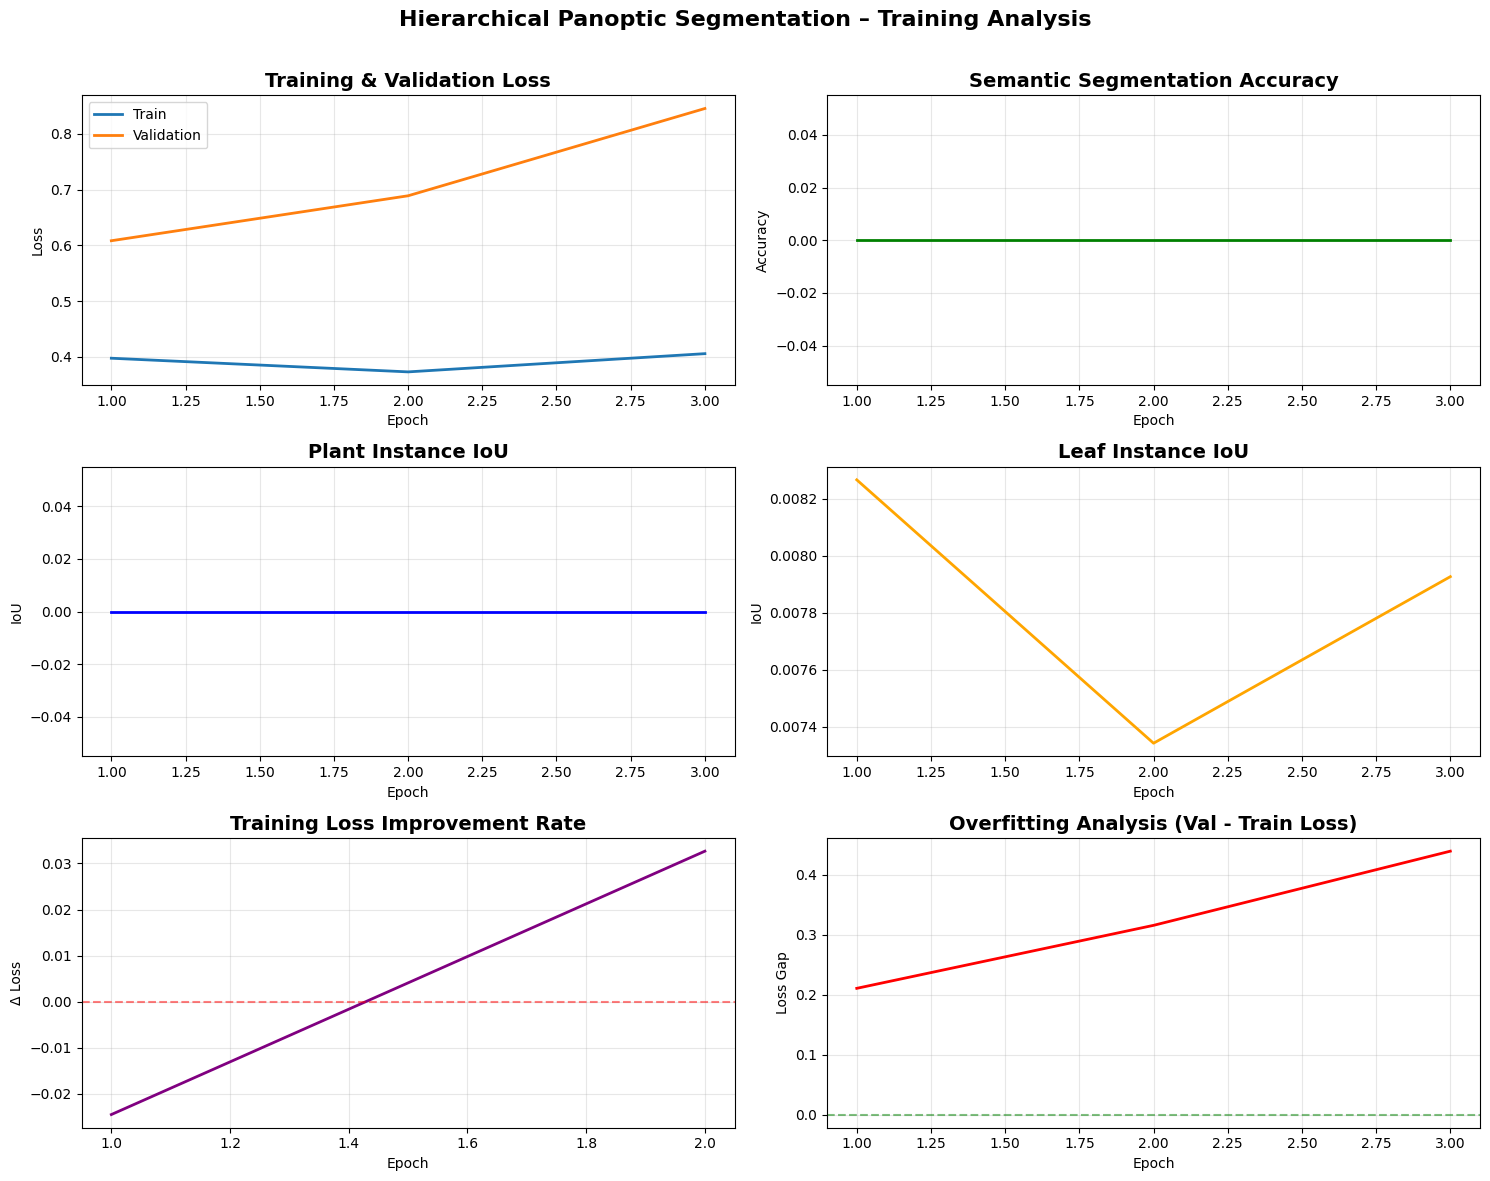


✅ Detailed training analysis saved to: /kaggle/working/hierarchical_panoptic_output/detailed_training_analysis.png


In [75]:
# ==============================================================
# 📊 Cell 22 (Kaggle): Plot Training History and Detailed Analysis
# ==============================================================
print("\n" + "="*70)
print("📈 GENERATING TRAINING VISUALIZATIONS (KAGGLE)")
print("="*70)

import os
import numpy as np
import matplotlib.pyplot as plt

# ✅ Create output dir if missing
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Base training history plot ---
try:
    plot_training_history(history)
    print(f"✅ Training curves saved to: {OUTPUT_DIR}/training_history.png")
except Exception as e:
    print(f"⚠️ Could not generate basic training curve: {e}")

# --- Detailed analysis plots ---
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle("Hierarchical Panoptic Segmentation – Training Analysis", fontsize=16, fontweight='bold')

# Safely extract metrics (avoid KeyError if some are missing)
def safe_get(metric, default=0):
    return history.get(metric, [default] * len(history['train_loss']))

epochs = range(1, len(history['train_loss']) + 1)

# 1️⃣ Training vs Validation Loss
axes[0, 0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2️⃣ Semantic Accuracy
semantic_acc = safe_get('semantic_acc')
axes[0, 1].plot(epochs, semantic_acc, color='green', linewidth=2)
axes[0, 1].set_title('Semantic Segmentation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].grid(True, alpha=0.3)

# 3️⃣ Plant IoU
plant_iou = safe_get('plant_iou')
axes[1, 0].plot(epochs, plant_iou, color='blue', linewidth=2)
axes[1, 0].set_title('Plant Instance IoU', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IoU')
axes[1, 0].grid(True, alpha=0.3)

# 4️⃣ Leaf IoU
leaf_iou = safe_get('leaf_iou')
axes[1, 1].plot(epochs, leaf_iou, color='orange', linewidth=2)
axes[1, 1].set_title('Leaf Instance IoU', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('IoU')
axes[1, 1].grid(True, alpha=0.3)

# 5️⃣ Training Loss Improvement
train_loss_diff = np.diff(history['train_loss'])
axes[2, 0].plot(range(1, len(train_loss_diff) + 1), train_loss_diff, color='purple', linewidth=2)
axes[2, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2, 0].set_title('Training Loss Improvement Rate', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Δ Loss')
axes[2, 0].grid(True, alpha=0.3)

# 6️⃣ Overfitting Analysis
gap = np.array(history['val_loss']) - np.array(history['train_loss'])
axes[2, 1].plot(epochs, gap, color='red', linewidth=2)
axes[2, 1].axhline(y=0, color='g', linestyle='--', alpha=0.5)
axes[2, 1].set_title('Overfitting Analysis (Val - Train Loss)', fontsize=14, fontweight='bold')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss Gap')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.97])
save_path = f"{OUTPUT_DIR}/detailed_training_analysis.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Detailed training analysis saved to: {save_path}")
print("="*70)
